# ETL made simple with PySpark. A beginner's guide. Part 1.

Created by: Kayla Brewer

In this workshop, we will create an ETL to extract crime data from different cities, transform it, and load it into a file. The datasets reflects reported incidents of crime that occurred in the Cities of San Francisco, Austin and Chicago during 2018. See the references at the end of this notebook for more information.

What will be covering?
- Installing and setting up PySpark
- Data Extraction
  - Read from Data Sources
  - Apply Schemas
  - Handling corrupt records
- Data Transformation
  - Several data transformations
  - Filtering data
  - Aggregations
  - Pandas Integration
  - Joins and lookup tables
- Data Load
  - Writing data to files
  - Repartition and coalesce
- Best Practices



# Installing and Setting Up Spark

In [0]:
# Installing Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Setting up the environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

PySpark isn't on sys.path by default, so that's why we use *finspark* to add it to sys.path at runtime. You need to import and call the *init()* method of findspark before calling PySpark.

In [0]:
import findspark
findspark.init()

For every Spark application, the first operation is to connect to the Spark master and get a
Spark session. This is an operation you will do every time. 

In [0]:
from pyspark.sql import SparkSession

# Getting a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Until now, we connected the Spark application (or driver) to the master and we got a Spark session. SparkSession is the new entry point for Spark applications starting on **Apache Spark 2.0**. Spark Session allows you to interact with underlying Spark functionality and programming Spark with DataFrame and Dataset APIs (Scala).

In order to get and load the data into our local machine we use the `wget` command.

In [0]:
# Get San Francisco Crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/San_Francisco_Crime_2018.csv

In [0]:
# Get Chicago crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/Chicago_Crimes_2018.csv

In [0]:
# Get Austin crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/Austin_Crime_Reports_2018.csv

In [0]:
# Get San Francisco corrupted data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/San_Francisco_Crime_2018_corrupt.csv

# DataFrames
A dataframe is both a data structure and an API. Once created (instantiated), a DataFrame object has methods attached to it. Methods are operations one can perform on DataFrames such as filtering, counting, aggregating and many others.

Dataframes, as well as datasets and RDDs (resilient distributed datasets), are considered immutable storage. When applied a method to an DataFrame, its state cannot be modified after it is created.

The `.` indicates you are *applying a method on the object*.


# Data Extraction

## Data Sources
Spark has six **core** data sources and hundreds of external data sources written by the community. Following are Spark’s core data
sources:
- [CSV](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv)
- [JSON](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json)
- [Parquet](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.parquet)
- [ORC](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.orc)
- [JDBC/ODBC](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.jdbc) connections
- [Plain-text](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.text) files

Some of the community-created data sources are:
- [Cassandra](https://docs.databricks.com/spark/latest/data-sources/cassandra.html)
- [MongoDB](https://docs.databricks.com/spark/latest/data-sources/mongodb.html)
- [AWS Redshift](https://docs.databricks.com/spark/latest/data-sources/aws/amazon-redshift.html)

## The Design Pattern

All connections to datasources work in much the same way, whether your data sits in S3, Cassandra, Redshift, Relational DB or another common data store.  The general pattern is always: 
 
 ```
 spark.read.options(<option key>, <option value>).<connection_type>(<endpoint>)
 ```.

The `connection_type` can be `csv`, `jdbc`, `parquet`, `json`, etc.

Let's start by reading the first file and saving it into a Spark DataFrame. As all good masters, the cluster manager doesn't do much, it relies on slaves or workers to do the job. 
Spark will do a distributed ingestion which means you will ask `n` workers to ingest the file at the same time.
The workers will create tasks to read the file. Each worker has access to the node’s memory and will assign a memory partition to the task. 

In [0]:
# Read the San Francisco DataFrame
sf_crimes = (spark.read                                      #spark.read
                  .option("header", "true")                  #.option(<option key>, <option value>)
                  .option("inferSchema", "true")             #.option(<option key>, <option value>)
                  .csv("San_Francisco_Crime_2018.csv")       #.<connection_type>(<endpoint>)
            )

In [0]:
sf_crimes.show(5)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+------------------+-------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|          Latitude|          Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+---

Also, you can use the following core structure for reading data: 
```
DataFrameReader.format(...).option("key", "value").schema(...).load()
```
The foundation for reading data in Spark is the [DataFrameReader](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader). We access this through the **SparkSession** via the read attribute:

`spark.read`

After we have a DataFrame reader, we specify several values:
- The format
- The schema
- The read mode
- A series of options

The *format*, *options*, and *schema* each return a DataFrameReader that can undergo further transformations and are all optional, except for one option. Each data source has a specific set of
options that determine how the data is read into Spark. At a minimum, you must supply the DataFrameReader a path to from which to read.

In [0]:
# Read the San Francisco DataFrame
sf_crimes = (spark.read                                      #spark.read
                  .format("csv")                             #The format
                  .option("mode", "FAILFAST")                #The read mode
                  .option("header", "true")                  #.option(<option key>, <option value>)
                  .option("inferSchema", "true")             #.option(<option key>, <option value>)
                  .load("San_Francisco_Crime_2018.csv")      #path to read
            )

In [0]:
sf_crimes.show(5)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+------------------+-------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|          Latitude|          Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+---

In [0]:
# Read the San Francisco DataFrame
sf_crimes = (spark.read                                             #spark.read
                  .format("csv")                                    #The format
                  .option("mode", "FAILFAST")                       #The read mode
                  .option("header", "true")                         #.option(<option key>, <option value>)
                  .option("inferSchema", "true")                    #.option(<option key>, <option value>)
                  .option("path", "San_Francisco_Crime_2018.csv")   #The path to read from
                  .load()  
            )

In [0]:
sf_crimes.show(5)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+------------------+-------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|          Latitude|          Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+---

**Exercise** - Reading the Austin Crime data

In [0]:
# Read the Austin Crime file and save it into a Dataframe
# TODO
austin_crimes = (spark.read                                             
                  .format("csv")                                    
                  .option("mode", "FAILFAST")                       
                  .option("header", "true")                         
                  .option("inferSchema", "true")
                  .load("Austin_Crime_Reports_2018.csv")  
            )

**Test your solution!**

In [0]:
# Run this cell to test your solution
rows_austin_crimes = austin_crimes.count()
expected = 102644
assert str(expected) == str(rows_austin_crimes), "{} does not equal expected {}".format(rows_austin_crimes, expected)

print("Tests passed")

Tests passed


**Exercise**  - Reading the Chicago crimes data 

In [0]:
# Read the Chicago crimes file and save it into a DataFrame
# TODO
chicago_crimes = (spark.read                                             
                  .format("csv")                                    
                  .option("mode", "FAILFAST")                       
                  .option("header", "true")                         
                  .option("inferSchema", "true")
                  .load("Chicago_Crimes_2018.csv")  
            )

**Test your solution!**

In [0]:
# Run this cell to test your solution
rows_chicago_crimes = chicago_crimes.count()
expected = 266963
assert str(expected) == str(rows_chicago_crimes), "{} does not equal expected {}".format(rows_chicago_crimes, expected)

print("Tests passed")

Tests passed


### Adding More Options

When you import that data into a cluster, you can add options based on the specific characteristics of the data. **`option`** is a method of `DataFrameReader`. Options are key/value pairs and must be specified before calling `.csv()`. For instance, options for reading CSV data include `header`, `delimiter`, and `inferSchema`.

Be aware that Spark doesn't read the header by default, so you would need to specify the `header` = True option every time you have a file with a header.

**NOTE**: You can find all the available options to pass along the core data sources:
- [CSV](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv)
- [JDBC](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.jdbc)
- [JSON](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json)

## Collecting Rows to the Driver
There are times when you’ll want to collect some of your data to the driver in order to manipulate it on your local machine.
Thus far, we did not explicitly define this operation. However, we used several different methods for doing so that are effectively all the same. [collect](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.collect) gets all data from the entire DataFrame,
[take](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.take) selects the first N rows, and [show](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.show) prints out a number of rows nicely.

In [0]:
sf_crimes.take(5) # take works with an Integer count

[Row(Incident Datetime='2018/12/31 11:57:00 PM', Incident Date='2018/12/31', Incident Time='23:57', Incident Year=2018, Incident Day of Week='Monday', Report Datetime='2019/01/01 12:02:00 AM', Row ID=75435104134, Incident ID=754351, Incident Number=190000015, CAD Number=183653767, Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code=4134, Incident Category='Assault', Incident Subcategory='Simple Assault', Incident Description='Battery', Resolution='Open or Active', Intersection='18TH ST \\ CASTRO ST', CNN=Decimal('25813000'), Police District='Mission', Analysis Neighborhood='Castro/Upper Market', Supervisor District=8, Latitude=37.76088893209152, Longitude=-122.4350007026991, point='(37.760888932092, -122.435000702699)'),
 Row(Incident Datetime='2018/12/31 11:55:00 PM', Incident Date='2018/12/31', Incident Time='23:55', Incident Year=2018, Incident Day of Week='Monday', Report Datetime='2019/01/01 12:05:00 AM', Row ID=75433719090, Incident ID=75433

The `show` method will print by default the first 20 records.

In [0]:
sf_crimes.show() # this prints it out nicely

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+------------------+-------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|  Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|          Latitude|          Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+-

In [0]:
sf_crimes.show(5, False)

+----------------------+-------------+-------------+-------------+--------------------+----------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+---------------------+-------------------------------------------+--------------------+-------------------------+--------+---------------+------------------------------+-------------------+------------------+-------------------+------------------------------------+
|Incident Datetime     |Incident Date|Incident Time|Incident Year|Incident Day of Week|Report Datetime       |Row ID     |Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category |Incident Subcategory |Incident Description                       |Resolution          |Intersection             |CNN     |Police District|Analysis Neighborhood         |Supervisor District|Latitude          |Longitude          |point     

In [0]:
sf_crimes.collect()

[Row(Incident Datetime='2018/12/31 11:57:00 PM', Incident Date='2018/12/31', Incident Time='23:57', Incident Year=2018, Incident Day of Week='Monday', Report Datetime='2019/01/01 12:02:00 AM', Row ID=75435104134, Incident ID=754351, Incident Number=190000015, CAD Number=183653767, Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code=4134, Incident Category='Assault', Incident Subcategory='Simple Assault', Incident Description='Battery', Resolution='Open or Active', Intersection='18TH ST \\ CASTRO ST', CNN=Decimal('25813000'), Police District='Mission', Analysis Neighborhood='Castro/Upper Market', Supervisor District=8, Latitude=37.76088893209152, Longitude=-122.4350007026991, point='(37.760888932092, -122.435000702699)'),
 Row(Incident Datetime='2018/12/31 11:55:00 PM', Incident Date='2018/12/31', Incident Time='23:55', Incident Year=2018, Incident Day of Week='Monday', Report Datetime='2019/01/01 12:05:00 AM', Row ID=75433719090, Incident ID=75433

**Exercise** - collecting rows

Let's try out some of this methods with the Austin and Chicago DataFrames.

By default, `show()` will print the first 20 rows. If you want to print something different than 20, you can pass the number of rows you would like to print as parameter.



In [0]:
# Print the first 5 rows of the Austin Crime DataFrame
# Collect all the Austin Crime DataFrame
# Select the first 2 rows of the Austin Crime DataFrame
# TODO
austin_crimes.show(5)
austin_crimes.collect()
austin_crimes.take(2)

+---------------+---------------------------+--------------------+---------------+--------------------+-------------+-------------+--------------------+-----------+-----------+--------------------+-----------------+--------+----------------+----------+------------+----+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence|  Occurred Date Time|Occurred Date|Occurred Time|    Report Date Time|Report Date|Report Time|       Location Type|          Address|Zip Code|Council District|APD Sector|APD District| PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single Member Council Districts|BOUNDARIES_si

[Row(Incident Number=20183652244, Highest Offense Description='DEADLY CONDUCT', Highest Offense Code=408, Family Violence='N', Occurred Date Time='12/31/2018 11:54:00 PM', Occurred Date='12/31/2018', Occurred Time=2354, Report Date Time='12/31/2018 11:54:00 PM', Report Date='12/31/2018', Report Time=2354, Location Type='RESIDENCE / HOME', Address='7605 EASTCREST DR', Zip Code=78752, Council District=4, APD Sector='ID', APD District='8', PRA=264, Census Tract=18.04, Clearance Status=None, Clearance Date=None, UCR Category='13A', Category Description='Aggravated Assault', X-coordinate=3125118, Y-coordinate=3125118, Latitude=30.33984945, Longitude=-97.70661753, Location='(30.33984945, -97.70661753)', Zip Codes=3641, Single Member Council Districts=4, BOUNDARIES_single_member_districts=9, Zoning Review Cases_data=None),
 Row(Incident Number=20183652210, Highest Offense Description='POSSESSION OF MARIJUANA', Highest Offense Code=1803, Family Violence='N', Occurred Date Time='12/31/2018 11:4

**Other DataFrame methods:**


*   **count**: Returns the number of rows in this DataFrame.
*   **columns**: Returns all column names as a list.
*   **dtypes**: Returns all column names and their data types as a list.
*   **describe**: Computes basic statistics for numeric and string columns. This include count, mean, stddev, min, and max. If no columns are given, this function computes statistics for all numerical or string columns.
*  **limit**: Limits the result count to the number specified.



**Exercise** - using other methods

Use the methods above to get the columns name and dtypes of each DataFrame.

In [0]:
# Get the columns name for sf_crimes DataFrame
# TODO
sf_crimes.columns

['Incident Datetime',
 'Incident Date',
 'Incident Time',
 'Incident Year',
 'Incident Day of Week',
 'Report Datetime',
 'Row ID',
 'Incident ID',
 'Incident Number',
 'CAD Number',
 'Report Type Code',
 'Report Type Description',
 'Filed Online',
 'Incident Code',
 'Incident Category',
 'Incident Subcategory',
 'Incident Description',
 'Resolution',
 'Intersection',
 'CNN',
 'Police District',
 'Analysis Neighborhood',
 'Supervisor District',
 'Latitude',
 'Longitude',
 'point']

In [0]:
# Get the dtypes for the austin_crimes DataFrame
# TODO
austin_crimes.dtypes

[('Incident Number', 'bigint'),
 ('Highest Offense Description', 'string'),
 ('Highest Offense Code', 'int'),
 ('Family Violence', 'string'),
 ('Occurred Date Time', 'string'),
 ('Occurred Date', 'string'),
 ('Occurred Time', 'int'),
 ('Report Date Time', 'string'),
 ('Report Date', 'string'),
 ('Report Time', 'int'),
 ('Location Type', 'string'),
 ('Address', 'string'),
 ('Zip Code', 'int'),
 ('Council District', 'int'),
 ('APD Sector', 'string'),
 ('APD District', 'string'),
 ('PRA', 'int'),
 ('Census Tract', 'double'),
 ('Clearance Status', 'string'),
 ('Clearance Date', 'string'),
 ('UCR Category', 'string'),
 ('Category Description', 'string'),
 ('X-coordinate', 'int'),
 ('Y-coordinate', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Location', 'string'),
 ('Zip Codes', 'int'),
 ('Single Member Council Districts', 'int'),
 ('BOUNDARIES_single_member_districts', 'int'),
 ('Zoning Review Cases_data', 'int')]

In [0]:
# Get the count of records for the chicago_crimes DataFrame
# TODO
chicago_crimes.count()

266963

## Applying Schemas

Schemas are at the heart of data structures in Spark. A schema describes the structure of your data by naming columns and declaring the type of data in that column. Rigorously enforcing schemas leads to significant performance optimizations and reliability of code.

Why is open source Spark so fast?
* First and foremost, Spark runs first in memory rather than reading and writing to disk.
* Second, using DataFrames allows Spark to optimize the execution of your queries because it knows what your data looks like.

**Schema Inference**

* Import data as a DataFrame and view its schema with the `printSchema()` DataFrame method.
* Store the schema as an object by calling `.schema` on a DataFrame. Schemas consist of a `StructType`, which is a collection of `StructField`s.  Each `StructField` gives a name and a type for a given field in the data.

You can see all the available Spark types here: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.types

To display the schema of the DataFrame, use the [printSchema](httphttps://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.printSchemas://) method.
This tells you the field name, field type, and whether the column is nullable or not (default is true)

In [0]:
sf_crimes.printSchema()

root
 |-- Incident Datetime: string (nullable = true)
 |-- Incident Date: string (nullable = true)
 |-- Incident Time: string (nullable = true)
 |-- Incident Year: integer (nullable = true)
 |-- Incident Day of Week: string (nullable = true)
 |-- Report Datetime: string (nullable = true)
 |-- Row ID: long (nullable = true)
 |-- Incident ID: integer (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- CAD Number: integer (nullable = true)
 |-- Report Type Code: string (nullable = true)
 |-- Report Type Description: string (nullable = true)
 |-- Filed Online: boolean (nullable = true)
 |-- Incident Code: integer (nullable = true)
 |-- Incident Category: string (nullable = true)
 |-- Incident Subcategory: string (nullable = true)
 |-- Incident Description: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Intersection: string (nullable = true)
 |-- CNN: decimal(8,0) (nullable = true)
 |-- Police District: string (nullable = true)
 |-- Analysis Neigh

In [0]:
sf_schema = sf_crimes.schema
print(sf_schema)

StructType(List(StructField(Incident Datetime,StringType,true),StructField(Incident Date,StringType,true),StructField(Incident Time,StringType,true),StructField(Incident Year,IntegerType,true),StructField(Incident Day of Week,StringType,true),StructField(Report Datetime,StringType,true),StructField(Row ID,LongType,true),StructField(Incident ID,IntegerType,true),StructField(Incident Number,IntegerType,true),StructField(CAD Number,IntegerType,true),StructField(Report Type Code,StringType,true),StructField(Report Type Description,StringType,true),StructField(Filed Online,BooleanType,true),StructField(Incident Code,IntegerType,true),StructField(Incident Category,StringType,true),StructField(Incident Subcategory,StringType,true),StructField(Incident Description,StringType,true),StructField(Resolution,StringType,true),StructField(Intersection,StringType,true),StructField(CNN,DecimalType(8,0),true),StructField(Police District,StringType,true),StructField(Analysis Neighborhood,StringType,true)

**Exercise** - Print a Schema

Take a look at the schema of the DataFrames: `austin_crimes` and `chicago_crimes`. See which fields are common between all DataFrames and which aren't.


In [0]:
# Check the Austin DataFrame schema
# TODO
austin_crimes.printSchema()

root
 |-- Incident Number: long (nullable = true)
 |-- Highest Offense Description: string (nullable = true)
 |-- Highest Offense Code: integer (nullable = true)
 |-- Family Violence: string (nullable = true)
 |-- Occurred Date Time: string (nullable = true)
 |-- Occurred Date: string (nullable = true)
 |-- Occurred Time: integer (nullable = true)
 |-- Report Date Time: string (nullable = true)
 |-- Report Date: string (nullable = true)
 |-- Report Time: integer (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Zip Code: integer (nullable = true)
 |-- Council District: integer (nullable = true)
 |-- APD Sector: string (nullable = true)
 |-- APD District: string (nullable = true)
 |-- PRA: integer (nullable = true)
 |-- Census Tract: double (nullable = true)
 |-- Clearance Status: string (nullable = true)
 |-- Clearance Date: string (nullable = true)
 |-- UCR Category: string (nullable = true)
 |-- Category Description: string (nu

In [0]:
# Assign the schema to a variable for the Austin DataFrame
# TODO
austin_schema = austin_crimes.schema
print(austin_schema)

StructType(List(StructField(Incident Number,LongType,true),StructField(Highest Offense Description,StringType,true),StructField(Highest Offense Code,IntegerType,true),StructField(Family Violence,StringType,true),StructField(Occurred Date Time,StringType,true),StructField(Occurred Date,StringType,true),StructField(Occurred Time,IntegerType,true),StructField(Report Date Time,StringType,true),StructField(Report Date,StringType,true),StructField(Report Time,IntegerType,true),StructField(Location Type,StringType,true),StructField(Address,StringType,true),StructField(Zip Code,IntegerType,true),StructField(Council District,IntegerType,true),StructField(APD Sector,StringType,true),StructField(APD District,StringType,true),StructField(PRA,IntegerType,true),StructField(Census Tract,DoubleType,true),StructField(Clearance Status,StringType,true),StructField(Clearance Date,StringType,true),StructField(UCR Category,StringType,true),StructField(Category Description,StringType,true),StructField(X-coor

In [0]:
# Check the Chicago DataFrame schema
# TODO
chicago_crimes.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Historical Wards 2003-2015: integer (nullable = true)
 |-- Zip Codes: integer (nullable = tr

In [0]:
# Assign the schema to a variable for the Chicago DataFrame
# TODO
chicago_schema = chicago_crimes.schema
print(chicago_schema)

StructType(List(StructField(ID,IntegerType,true),StructField(Case Number,StringType,true),StructField(Date,StringType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,BooleanType,true),StructField(Domestic,BooleanType,true),StructField(Beat,IntegerType,true),StructField(District,IntegerType,true),StructField(Ward,IntegerType,true),StructField(Community Area,IntegerType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,IntegerType,true),StructField(Y Coordinate,IntegerType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true),StructField(Historical Wards 2003-2015,IntegerType,true),StructField(Zip Codes,IntegerType,true),StructField(Community Areas,Integ

Import the necessary types from the `types` module. Build a `StructType`, which takes a list of `StructField`s.  Each `StructField` takes three arguments: the name of the field, the type of data in it, and a `Boolean` for whether this field can be `Null`.

In [0]:
# Defining the San Francisco DataFrame Schema
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DecimalType, DoubleType, BooleanType
             
sf_schema = StructType([StructField("Incident Datetime",StringType(),True),
                StructField("Incident Date",StringType(),True),
                StructField("Incident Time",StringType(),True),
                StructField("Incident Year",IntegerType(),True),
                StructField("Incident Day of Week",StringType(),True),
                StructField("Report Datetime",StringType(),True),
                StructField("Row ID",LongType(),True),
                StructField("Incident ID",IntegerType(),True),
                StructField("Incident Number",IntegerType(),True),
                StructField("CAD Number",IntegerType(),True),
                StructField("Report Type Code",StringType(),True),
                StructField("Report Type Description",StringType(),True),
                StructField("Filed Online",BooleanType(),True),
                StructField("Incident Code",IntegerType(),True),
                StructField("Incident Category",StringType(),True),
                StructField("Incident Subcategory",StringType(),True),
                StructField("Incident Description",StringType(),True),
                StructField("Resolution",StringType(),True),
                StructField("Intersection",StringType(),True),
                StructField("CNN",DecimalType(8,0),True),
                StructField("Police District",StringType(),True),
                StructField("Analysis Neighborhood",StringType(),True),
                StructField("Supervisor District",IntegerType(),True),
                StructField("Latitude",DoubleType(),True),
                StructField("Longitude",DoubleType(),True),
                StructField("point",StringType(),True)])

In [0]:
print(sf_schema)

StructType(List(StructField(Incident Datetime,StringType,true),StructField(Incident Date,StringType,true),StructField(Incident Time,StringType,true),StructField(Incident Year,IntegerType,true),StructField(Incident Day of Week,StringType,true),StructField(Report Datetime,StringType,true),StructField(Row ID,LongType,true),StructField(Incident ID,IntegerType,true),StructField(Incident Number,IntegerType,true),StructField(CAD Number,IntegerType,true),StructField(Report Type Code,StringType,true),StructField(Report Type Description,StringType,true),StructField(Filed Online,BooleanType,true),StructField(Incident Code,IntegerType,true),StructField(Incident Category,StringType,true),StructField(Incident Subcategory,StringType,true),StructField(Incident Description,StringType,true),StructField(Resolution,StringType,true),StructField(Intersection,StringType,true),StructField(CNN,DecimalType(8,0),true),StructField(Police District,StringType,true),StructField(Analysis Neighborhood,StringType,true)

Apply the schema using the `.schema` method. This `read` returns only  the columns specified in the schema.
 A `LongType` is an 8-byte integer ranging up to 9,223,372,036,854,775,807 while `IntegerType` is a 4-byte integer ranging up to 2,147,483,647.

In [0]:
# Reading the San Francisco DataFrame with a user defined schema
sf_crimes2 = (spark.read
                  .format("csv")
                  .schema(sf_schema)
                  .option("header", "true")            
                  .load("San_Francisco_Crime_2018.csv")
            )

In [0]:
sf_crimes2.show(5)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+------------------+-------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|          Latitude|          Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+---

**Benefits of user defined schemas include**:

* Avoiding the extra scan of your data needed to infer the schema
* Providing alternative data types
* Parsing only the fields you need (JSON files)

In [0]:
chicago_crimes.schema

StructType(List(StructField(ID,IntegerType,true),StructField(Case Number,StringType,true),StructField(Date,StringType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,BooleanType,true),StructField(Domestic,BooleanType,true),StructField(Beat,IntegerType,true),StructField(District,IntegerType,true),StructField(Ward,IntegerType,true),StructField(Community Area,IntegerType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,IntegerType,true),StructField(Y Coordinate,IntegerType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true),StructField(Historical Wards 2003-2015,IntegerType,true),StructField(Zip Codes,IntegerType,true),StructField(Community Areas,Integ

**Exercise (Optional)** - Defining the Chicago crime data schema

In [0]:
# Define a schema "chicago_schema" for the Chicago crime DataFrame
# Read the Chicago data using the schema you just defined
# TODO
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, BooleanType

chicago_schema = StructType([StructField("ID",IntegerType(),True),
            StructField("Case Number",StringType(),True),
            StructField("Date",StringType(),True),
            StructField("Block",StringType(),True),
            StructField("IUCR",StringType(),True),
            StructField("Primary Type",StringType(),True),
            StructField("Description",StringType(),True),
            StructField("Location Description",StringType(),True),
            StructField("Arrest",BooleanType(),True),
            StructField("Domestic",BooleanType(),True),
            StructField("Beat",IntegerType(),True),
            StructField("District",IntegerType(),True),
            StructField("Ward",IntegerType(),True),
            StructField("Community Area",IntegerType(),True),
            StructField("FBI Code",StringType(),True),
            StructField("X Coordinate",IntegerType(),True),
            StructField("Y Coordinate",IntegerType(),True),
            StructField("Year",IntegerType(),True),
            StructField("Updated On",StringType(),True),
            StructField("Latitude",DoubleType(),True),
            StructField("Longitude",DoubleType(),True),
            StructField("Location",StringType(),True),
            StructField("Historical Wards 2003-2015",IntegerType(),True),
            StructField("Zip Codes",IntegerType(),True),
            StructField("Community Areas",IntegerType(),True),
            StructField("Census Tracts",IntegerType(),True),
            StructField("Wards",IntegerType(),True),
            StructField("Boundaries - ZIP Codes",IntegerType(),True),
            StructField("Police Districts",IntegerType(),True),
            StructField("Police Beats",IntegerType(),True)])

In [0]:
# Reading the Chicago DataFrame with a user defined schema
chicago_crimes2 = (spark.read
                        .format("csv")
                        .schema(chicago_schema)
                        .option("header", "true")            
                        .load("Chicago_Crimes_2018.csv")
                  )
chicago_crimes2.show(2)

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+---

## Handling Corrupt Records

ETL pipelines need robust solutions to handle corrupt data. This is because data corruption scales as the size of data and complexity of the data application grow. Corrupt data includes:

* Missing information
* Incomplete information
* Schema mismatch
* Differing formats or data types
* User errors when writing data producers

Since ETL pipelines are built to be automated, production-oriented solutions must ensure pipelines behave as expected. This means that data engineers must both expect and systematically handle corrupt records.

### Read modes
Reading data from an external source naturally entails encountering malformed data, especially when working with only semi-structured data sources. Read modes specify what will happen
when Spark does come across malformed records.

![alt text](https://images-workshop.s3.amazonaws.com/Spark_read_modes.png)

Source: Spark: The Definitive Guide. Big Data Processing Made Simple By Matei Zaharia, Bill Chambers

The default is *permissive*.

### Permissive mode
Sets all fields to `null` when it encounters a corrupted record and places all corrupted records in a string column called `corrupt_record`.
You will need to add this column to your schema if you are manually defining it.

Let's see what happens when we commented out one of the schema fields.

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DecimalType, DoubleType, BooleanType
             
sf_schema = StructType([StructField("Incident Datetime",StringType(),True),
                StructField("Incident Date",StringType(),True),
                StructField("Incident Time",StringType(),True),
                StructField("Incident Year",IntegerType(),True),
                StructField("Incident Day of Week",StringType(),True),
                StructField("Report Datetime",StringType(),True),
                StructField("Row ID",LongType(),True),
                StructField("Incident ID",IntegerType(),True),
                StructField("Incident Number",IntegerType(),True),
                # StructField("CAD Number",IntegerType(),True),
                StructField("Report Type Code", StringType(),True),
                StructField("Report Type Description",StringType(),True),
                StructField("Filed Online",BooleanType(),True),
                StructField("Incident Code",IntegerType(),True),
                StructField("Incident Category",StringType(),True),
                StructField("Incident Subcategory",StringType(),True),
                StructField("Incident Description",StringType(),True),
                StructField("Resolution",StringType(),True),
                StructField("Intersection",StringType(),True),
                StructField("CNN",DecimalType(8,0),True),
                StructField("Police District",StringType(),True),
                StructField("Analysis Neighborhood",StringType(),True),
                StructField("Supervisor District",IntegerType(),True),
                StructField("Latitude",DoubleType(),True),
                StructField("Longitude",DoubleType(),True),
                StructField("point",StringType(),True),
                StructField("_corrupt_record", StringType(), True)
                ])

We just ignored one of the columns in the csv file. When Sparks meets a corrupted record in a CSV, it puts the malformed string into a field configured by `columnNameOfCorruptRecord`, and sets other fields to null.
Let's see what happen when we read the file using an user-define schema. 

**NOTE:** you should set a string type field named `_corrupt_record` in an user-defined schema to get the corrupt records.

In [0]:
# Read the San Francisco DataFrame using permissive mode
from pyspark.sql.functions import col

sf_crimes2 = (spark.read
                  .schema(sf_schema)
                  .format("csv")
                  .option("mode", "permissive")
                  .option("header", "true") 
                  .load("San_Francisco_Crime_2018.csv")
            )

sf_crimes2.show(5)

+-----------------+-------------+-------------+-------------+--------------------+---------------+------+-----------+---------------+----------------+-----------------------+------------+-------------+-----------------+--------------------+--------------------+----------+------------+----+---------------+---------------------+-------------------+--------+---------+-----+--------------------+
|Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|Report Datetime|Row ID|Incident ID|Incident Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category|Incident Subcategory|Incident Description|Resolution|Intersection| CNN|Police District|Analysis Neighborhood|Supervisor District|Latitude|Longitude|point|     _corrupt_record|
+-----------------+-------------+-------------+-------------+--------------------+---------------+------+-----------+---------------+----------------+-----------------------+------------+-------------+---------

What about if we have a file where some records have less/more fields? When it meets a record having fewer tokens than the length of the schema, it will set to null to extra fields. When the record has more tokens than the length of the schema, it drops extra tokens. In both cases, the `_corrupt_record` will contain the string value of the whole row.

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DecimalType, DoubleType, BooleanType
             
sf_schema = StructType([StructField("Incident Datetime",StringType(),True),
                StructField("Incident Date",StringType(),True),
                StructField("Incident Time",StringType(),True),
                StructField("Incident Year",IntegerType(),True),
                StructField("Incident Day of Week",StringType(),True),
                StructField("Report Datetime",StringType(),True),
                StructField("Row ID",LongType(),True),
                StructField("Incident ID",IntegerType(),True),
                StructField("Incident Number",IntegerType(),True),
                StructField("CAD Number",IntegerType(),True),
                StructField("Report Type Code", StringType(),True),
                StructField("Report Type Description",StringType(),True),
                StructField("Filed Online",BooleanType(),True),
                StructField("Incident Code",IntegerType(),True),
                StructField("Incident Category",StringType(),True),
                StructField("Incident Subcategory",StringType(),True),
                StructField("Incident Description",StringType(),True),
                StructField("Resolution",StringType(),True),
                StructField("Intersection",StringType(),True),
                StructField("CNN",DecimalType(8,0),True),
                StructField("Police District",StringType(),True),
                StructField("Analysis Neighborhood",StringType(),True),
                StructField("Supervisor District",IntegerType(),True),
                StructField("Latitude",DoubleType(),True),
                StructField("Longitude",DoubleType(),True),
                StructField("point",StringType(),True),
                StructField("_corrupt_record",StringType(), True)
                ])

In [0]:
# Read the San Francisco DataFrame using permissive mode with corrupted records
from pyspark.sql.functions import col

sf_crimes2 = (spark.read
                  .format("csv")
                  .schema(sf_schema)
                  .option("mode", "permissive")
                  .option("header", "true")            
                  .load("San_Francisco_Crime_2018_corrupt.csv")
            )

sf_crimes2.filter(col("_corrupt_record").isNotNull()).show(truncate=False)

+----------------------+-------------+-------------+-------------+--------------------+----------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-----------------+----------------------+---------------------------------+--------------+-----------------------+--------+---------------+---------------------+-------------------+-----------------+-------------------+------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Incident Datetime     |Incident Date|Incident Time|Incident Year|Incident Day of Week|Report Datetime       |Row ID     |Incident ID|Incident Number|CAD

Let's see now the record with less columns. Spark just assigned NULL to those columns (Longitude, point).

In [0]:
sf_crimes2.filter((col("Incident Datetime")=="2018/12/31 11:15:00 PM") & (col("Report Datetime")=="2019/01/01 11:26:00 PM")).show()

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-----------------+--------------------+--------------------+--------------+--------------------+--------+---------------+---------------------+-------------------+-----------------+---------+-----+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category|Incident Subcategory|Incident Description|    Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|         Latitude|Longitude|point|     _corrupt_record|
+--------------------+-------------+-------------+-------------+--------------------+--------------------+------

Below is the record with extra columns. See how the original record contained the last column with the value of "Testing" and how it has been removed from the data that was read into the DataFrame.

In [0]:
sf_crimes2.filter(col("Incident Datetime")=="2018/12/30 11:10:00 PM").first()["_corrupt_record"]

'2018/12/30 11:10:00 PM,2018/12/30,23:10,2018,Sunday,2019/01/02 12:33:00 PM,75514206244,755142,196000750,,II,Coplogic Initial,true,06244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,LOMBARD ST \\ WEBSTER ST,26748000,Northern,Marina,2,37.80005154768055,-122.43440469982856,"(37.800051547681, -122.434404699829)", Testing'

### Failfast mode
Fails immediately upon finding a corrupted record.

Let's see what happens when we load a file with less records.

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DecimalType, DoubleType, BooleanType

sf_schema = StructType([StructField("Incident Datetime",StringType(),True),
                StructField("Incident Date",StringType(),True),
                StructField("Incident Time",StringType(),True),
                StructField("Incident Year",IntegerType(),True),
                StructField("Incident Day of Week",StringType(),True),
                StructField("Report Datetime",StringType(),True),
                StructField("Row ID",LongType(),True),
                StructField("Incident ID",IntegerType(),True),
                StructField("Incident Number",IntegerType(),True),
                StructField("CAD Number",IntegerType(),True),
                StructField("Report Type Code", StringType(),True),
                StructField("Report Type Description",StringType(),True),
                StructField("Filed Online",BooleanType(),True),
                StructField("Incident Code",IntegerType(),True),
                StructField("Incident Category",StringType(),True),
                StructField("Incident Subcategory",StringType(),True),
                StructField("Incident Description",StringType(),True),
                StructField("Resolution",StringType(),True),
                StructField("Intersection",StringType(),True),
                StructField("CNN",DecimalType(8,0),True),
                StructField("Police District",StringType(),True),
                StructField("Analysis Neighborhood",StringType(),True),
                StructField("Supervisor District",IntegerType(),True),
                StructField("Latitude",DoubleType(),True),
                StructField("Longitude",DoubleType(),True),
                StructField("point",StringType(),True)
                ])

In [0]:
# Read the San Francisco DataFrame using failfast mode 
# sf_crimes3 = (spark.read
#                   .schema(sf_schema)
#                   .format("csv")
#                   .option("mode", "failfast")
#                   .option("header", "true")          
#                   .load("San_Francisco_Crime_2018_corrupt.csv")
#             )

# sf_crimes3.show()

### DropMalformed mode
Now, let's see how our two malformed records get dropped from our corrupt DataFrame. If we read our data again using the permissive mode and we compare with our original dataFrame we can see below the total number of records we should have.

In [0]:
# Read the San Francisco DataFrame using permissive mode 
sf_crimes2 = (spark.read
                  .schema(sf_schema)
                  .format("csv")
                  .option("mode", "permissive")
                  .option("header", "true")            
                  .load("San_Francisco_Crime_2018_corrupt.csv")
            )

In [0]:
# DataFrame read with permissive mode
sf_crimes2.count()

154532

In [0]:
# Original DataFrame
sf_crimes.count()

154532

**Exercise** - DropMalformed mode

Try to read the file using the `dropMalformed` mode and check whether the new DataFrame has two less records.

In [0]:
# Use DropMalformed mode to read the San Francisco crime file with corrupt records
# Filename: San_Francisco_Crime_2018_corrupt.csv
# TODO
sf_crimes4 = (spark.read
                  .schema(sf_schema)
                  .format("csv")
                  .option("mode", "dropmalformed")
                  .option("header", "true")            
                  .load("San_Francisco_Crime_2018_corrupt.csv")
            )
sf_crimes4.count()

154530

**Test your solution!**

In [0]:
# Run this cell to test your solution

rows_sf_crimes2 = sf_crimes4.count()
expected = 154530
assert str(expected) == str(rows_sf_crimes2), "{} does not equal expected {}".format(rows_sf_crimes2, expected)

print("Tests passed")

Tests passed


# Data Transformation

Each DataFrame has different field names and values for its crime data. We need to do a set of tranformation tasks that will normalize all this data so we can append it together. Between those tasks we find:
- Adding new columns from missing fields like `Row ID`, `Incident Year` and `Incident Day of Week`.
- Adding new column with the name of the `City` so we can append all three DataFrames later.
- Casting string fields to Timestamps with the same format across DataFrames (E.g. yyyy-MM-dd HH:mm:ss)
- Casting some field from boolean or integer to string type. (E.g. `Arrest` and `District` in Chicago Crimes DataFrame)
- Rename columns to match our appended DataFrame. Notice that all three DataFrames use different names for the columns.

You can find in the table below the columns names for each DataFrame:


| Final DF Column| San Francisco Column | Austin Column | Chicago Column | 
| --- | --- | --- | --- |
| Row ID | Row ID | N/A | ID | 
|Incident Number| Incident Number | Incident Number | Case Number | 
|Incident Code| Incident Code | Highest Offense Code | IUCR |
|Incident Category| Incident Category  | Highest Offense Description | Primary Type | 
|Incident Datetime| Incident Datetime | Occurred Date Time | Date |  
|Incident Date| Incident Date | Occurred Date | N/A |  
|Incident Year| Incident Year | N/A | Year |  
|Incident Day of Week| Incident Day of Week | N/A | N/A |  
|Report Date Time| Report Date Time | Report Date Time | N/A |  
|Address| Intersection | Address | Block | 
|Latitude| Latitude | Latitude | Latitude |
|Longitude| Longitude | Longitude | Longitude | 
|Location| point | Location | Location |
|Supervisor District| Supervisor District | Council District | Ward | 
|Resolution| Resolution | Clearance Status | Arrest | 
|City|N/A|N/A|N/A|

## Records and Rows
In Spark, each row in a DataFrame is a single record. Spark represents this record as an object of type Row. Spark manipulates Row objects using column expressions in order to produce usable
values. Row objects internally represent arrays of bytes. The byte array interface is never shown to users because we only use column expressions to manipulate them.
You’ll notice commands that return individual rows to the driver will always return one or more Row types when we are working with DataFrames.

In [0]:
sf_crimes.first()

Row(Incident Datetime='2018/12/31 11:57:00 PM', Incident Date='2018/12/31', Incident Time='23:57', Incident Year=2018, Incident Day of Week='Monday', Report Datetime='2019/01/01 12:02:00 AM', Row ID=75435104134, Incident ID=754351, Incident Number=190000015, CAD Number=183653767, Report Type Code='II', Report Type Description='Initial', Filed Online=None, Incident Code=4134, Incident Category='Assault', Incident Subcategory='Simple Assault', Incident Description='Battery', Resolution='Open or Active', Intersection='18TH ST \\ CASTRO ST', CNN=Decimal('25813000'), Police District='Mission', Analysis Neighborhood='Castro/Upper Market', Supervisor District=8, Latitude=37.76088893209152, Longitude=-122.4350007026991, point='(37.760888932092, -122.435000702699)')

## Converting to Spark Types (Literals)
Sometimes, we need to pass explicit values into Spark that are just a value (rather than a new column). This might be a constant value or something we’ll need to compare to later on. The
way we do this is through literals. This is basically a translation from a given programming language’s literal value to one that Spark understands. Literals are expressions and you can use
them by defining a string as parameter in the [lit](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lit) method:

E.g. lit("San Francisco")

## Adding Columns
There’s also a more formal way of adding a new column to a DataFrame, and that’s by using the [withColumn](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn) method.
Let's combine the `withColumn` and `lit` methods to add a new column containing the city name to each of the DataFrames.



In [0]:
# Adding a city column
from pyspark.sql.functions import lit

sf_crimes.withColumn("City", lit("San Francisco"))

sf_crimes.show(1)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-----------------+--------------------+--------------------+--------------+-------------------+--------+---------------+---------------------+-------------------+-----------------+------------------+--------------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category|Incident Subcategory|Incident Description|    Resolution|       Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|         Latitude|         Longitude|               point|
+--------------------+-------------+-------------+-------------+--------------------+--------------------+--

**Why can't we see the new column on the Dataframe?**

Dataframes, as well as datasets and RDDs (resilient distributed datasets), are considered immutable storage. Immutability is defined as unchangeable. When applied to an object, it means its state cannot be modified after it is created. 

In [0]:
# Adding a city column
from pyspark.sql.functions import lit

sf_crimes = sf_crimes.withColumn("City", lit("San Francisco"))
austin_crimes = austin_crimes.withColumn("City", lit("Austin"))
chicago_crimes = chicago_crimes.withColumn("City", lit("Chicago"))

sf_crimes.show(1)
austin_crimes.show(1)
chicago_crimes.show(1)

+--------------------+-------------+-------------+-------------+--------------------+--------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-----------------+--------------------+--------------------+--------------+-------------------+--------+---------------+---------------------+-------------------+-----------------+------------------+--------------------+-------------+
|   Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|     Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category|Incident Subcategory|Incident Description|    Resolution|       Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|         Latitude|         Longitude|               point|         City|
+--------------------+-------------+-------------+-------------+----------------

Let's add a `Row ID` column for the Austin Crimes DataFrame as well as the `Incident Year` and `Incident Day of Week`.

In [0]:
# Adding the Row ID column
from pyspark.sql.functions import row_number, lit
from pyspark.sql.window import Window

# Window orderBy is required
w = Window.orderBy(austin_crimes.columns)
austin_crimes = austin_crimes.withColumn("Row ID", row_number().over(w))

austin_crimes.show(2)

+---------------+---------------------------+--------------------+---------------+--------------------+-------------+-------------+--------------------+-----------+-----------+----------------+-------------------+--------+----------------+----------+------------+---+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+------+------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence|  Occurred Date Time|Occurred Date|Occurred Time|    Report Date Time|Report Date|Report Time|   Location Type|            Address|Zip Code|Council District|APD Sector|APD District|PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single Member Council Districts|BOUND

Notice that the **`withColumn`** function takes two arguments: the column name and the expression that will create the value for that given row in the DataFrame. Interestingly, we can also rename
a column this way. 

In the example above it was also introduced a new set of utilities functions call [Window](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Window). You can find more information about it [here](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html)

## Changing a Column’s Type (cast)
Sometimes, we might need to convert from one type to another; for example, if we have a set of StringType that should be integers or datetime. We can convert columns from one type to another by
casting the column from one type to another. 

Let's use the [unix_timestamp](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.unix_timestamp) to convert time string to a specific pattern, by default - ‘yyyy-MM-dd HH:mm:ss’ and the [cast](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast) method to change it to a Timestamp.

In [0]:
# Casting the date columns from String to Timestamp
from pyspark.sql.functions import unix_timestamp, to_date
from pyspark.sql.types import TimestampType

sf_crimes = sf_crimes.withColumn("Incident Datetime", unix_timestamp("Incident Datetime", "yyyy/MM/dd HH:mm:ss").cast(TimestampType()))
sf_crimes = sf_crimes.withColumn("Incident Date", to_date("Incident Date", "yyyy/MM/dd"))
sf_crimes = sf_crimes.withColumn("Report Datetime", unix_timestamp("Report Datetime", "yyyy/MM/dd HH:mm:ss").cast(TimestampType()))

sf_crimes.show(2)

+-------------------+-------------+-------------+-------------+--------------------+-------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+---------------------+-------------------+-----------------+-------------------+--------------------+-------------+
|  Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|    Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description|          Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|         Latitude|          Longitude|               point|         City|
+-------------------+-------------+-------------+-------------+---

In [0]:
# Adding the Incident Year and Incident Day of Week columns
# Casting the dates columns from String to Timestamp
from pyspark.sql.functions import year, dayofweek, unix_timestamp
from pyspark.sql.types import TimestampType

austin_crimes = austin_crimes.withColumn("Occurred Date Time", unix_timestamp("Occurred Date Time", "MM/dd/yyyy HH:mm:ss").cast(TimestampType()))
austin_crimes = austin_crimes.withColumn("Occurred Date", to_date("Occurred Date", "MM/dd/yyyy"))
austin_crimes = austin_crimes.withColumn("Report Date Time", unix_timestamp("Report Date Time", "MM/dd/yyyy HH:mm:ss").cast(TimestampType()))
austin_crimes = austin_crimes.withColumn("Incident Year", year(unix_timestamp("Occurred Date Time", "MM/dd/yyyy HH:mm:ss").cast(TimestampType())))
austin_crimes = austin_crimes.withColumn("Incident Day of Week", dayofweek(unix_timestamp("Occurred Date Time", "MM/dd/yyyy HH:mm:ss").cast(TimestampType())))

austin_crimes.show(2)

+---------------+---------------------------+--------------------+---------------+-------------------+-------------+-------------+-------------------+-----------+-----------+----------------+-------------------+--------+----------------+----------+------------+---+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+------+------+-------------+--------------------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence| Occurred Date Time|Occurred Date|Occurred Time|   Report Date Time|Report Date|Report Time|   Location Type|            Address|Zip Code|Council District|APD Sector|APD District|PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single

**Exercise** - Add/Cast columns in Chicago DataFrame

- Convert `date` field to the right Timestamp format.
- Create the columns `Incident Date` and `Incident Day of Week` from the `Date` column.
- Create a new column for `Report Datetime`.
- Cast the `Arrest` column from integer to string type.

Use both the `unix_timestamp` and `cast` functions.

In [0]:
# Convert "Date" column to Timestamp
# Create "Incident Date" and "Incident Day of Week" from "Date" column
# Create new "Report Datetime". Decide whether leave it as NULL or assign the "Incident Date" to it.
# Cast the "Arrest" to a String type
# TODO

from pyspark.sql.functions import to_date, dayofweek, unix_timestamp, hour, minute, second, lit, col
from pyspark.sql.types import TimestampType, StringType

incident_datetime = unix_timestamp("Date", "MM/dd/yyyy HH:mm:ss").cast(TimestampType())

chicago_crimes = chicago_crimes.withColumn("Date", incident_datetime)
chicago_crimes = chicago_crimes.withColumn("Incident Date", to_date(incident_datetime))
chicago_crimes = chicago_crimes.withColumn("Incident Day of Week", dayofweek(incident_datetime))
# chicago_crimes = chicago_crimes.withColumn("Report Datetime", lit(None).cast(StringType())) # we can leave it as NULL
chicago_crimes = chicago_crimes.withColumn("Report Datetime", col("Date")) # or we can assign the same Incident Date
chicago_crimes = chicago_crimes.withColumn("Arrest", col("Arrest").cast(StringType()))

chicago_crimes.show(2)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-------+-------------+--------------------+-------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|   City|Incident Date|Incident Day of Week|    Report Datetime|
+--------+-----------+-------------------+--

**Test your solution!**

In [0]:
# Run this cell to test your solution
from pyspark.sql.types import TimestampType, StringType
cols = chicago_crimes.columns

expected = True
assert str(expected) == str("Incident Date" in cols), "{} does not equal expected {}".format("Incident Date" in cols, expected)
assert str(expected) == str("Incident Day of Week" in cols), "{} does not equal expected {}".format("Incident Day of Week" in cols, expected)
assert str(expected) == str("Report Datetime" in cols), "{} does not equal expected {}".format("Report Datetime" in cols, expected)

assert expected == isinstance(chicago_crimes.schema["Date"].dataType, TimestampType),"{} does not equal expected {}".format(isinstance(chicago_crimes.schema["Date"].dataType, TimestampType), expected)
assert expected == isinstance(chicago_crimes.schema["Arrest"].dataType, StringType),"{} does not equal expected {}".format(isinstance(chicago_crimes.schema["Arrest"].dataType, TimestampType), expected)

print("Tests passed")

Tests passed


## Replace column values



In order to replace all values in a certain column according to their current value we use the [replace](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameNaFunctions.replace) method. The only requirement is
that this value be the same type as the original value.

As we saw above, each City has different values on the `Resolution` column so we need to normalize those values and replace them.
Follow the below table to replace the values:

|San Francisco values| Austin values | Chicago values |
|--|--|--|
|Cite or Arrest Adult|C-Cleared by Arrest|true-Arrest was made|
|Cite or Arrest Juvenile|O-Cleared by Exception|false-Arrest wasn't made|
|Exceptional Adult|N-Not cleared||
|Exceptional Juvenile|||
|Open or Active|||
|Unfounded|||

In [0]:
# Replace different values for Cleared/Not Cleared
sf_crimes = (sf_crimes.replace("Cite or Arrest Adult", "Cleared", ["Resolution"])
                      .replace("Cite or Arrest Juvenile", "Cleared", ["Resolution"])
                      .replace("Exceptional Adult", "Cleared", ["Resolution"])
                      .replace("Exceptional Juvenile", "Cleared", ["Resolution"])
                      .replace("Open or Active", "Not Cleared", ["Resolution"])
                      .replace("Unfounded", "Cleared", ["Resolution"])
            )

sf_crimes.show(2)

+-------------------+-------------+-------------+-------------+--------------------+-------------------+-----------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+------------------+--------------------+--------------------+-----------+--------------------+--------+---------------+---------------------+-------------------+-----------------+-------------------+--------------------+-------------+
|  Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|    Report Datetime|     Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code| Incident Category|Incident Subcategory|Incident Description| Resolution|        Intersection|     CNN|Police District|Analysis Neighborhood|Supervisor District|         Latitude|          Longitude|               point|         City|
+-------------------+-------------+-------------+-------------+--------------------+

**Exercise** - Replace Resolution values

Let's do the same replacement for both, the Austin and Chicago DataFrames.

In [0]:
# Replace the "Clearance Status" column values on Austin DataFrame
# Replace "C" and "O" for "Cleared"
# Replace "N" for "Not Cleared"
# TODO

austin_crimes = (austin_crimes.replace("C","Cleared", ["Clearance Status"])
                              .replace("O","Cleared", ["Clearance Status"])
                              .replace("N","Not Cleared", ["Clearance Status"])
                )
austin_crimes.show(2)

+---------------+---------------------------+--------------------+---------------+-------------------+-------------+-------------+-------------------+-----------+-----------+----------------+-------------------+--------+----------------+----------+------------+---+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+------+------+-------------+--------------------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence| Occurred Date Time|Occurred Date|Occurred Time|   Report Date Time|Report Date|Report Time|   Location Type|            Address|Zip Code|Council District|APD Sector|APD District|PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single

**Test your solution!**

In [0]:
# Run this cell to test your solution
values = austin_crimes.select("Clearance Status").distinct().collect()
values_str = []

for value in values:
  values_str.append(value["Clearance Status"])

expected = True
assert str(expected) == str("Cleared" in values_str), "{} does not equal expected {}".format("Cleared" in values_str, expected)
assert str(expected) == str("Not Cleared" in values_str), "{} does not equal expected {}".format("Not Cleared" in values_str, expected)
assert str(expected) == str(None in values_str), "{} does not equal expected {}".format(None in values_str, expected)

print("Tests passed")

Tests passed


In [0]:
# Replace the "Arrest" column values on Chicago DataFrame
# Replace "true" value for "Cleared"
# Replace "false" value for "Not Cleared"
# TODO

chicago_crimes = (chicago_crimes.replace("true","Cleared", ["Arrest"])
                              .replace("false","Not Cleared", ["Arrest"])
                )
chicago_crimes.show(2)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+-----------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-------+-------------+--------------------+-------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|     Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|   City|Incident Date|Incident Day of Week|    Report Datetime|
+--------+-----------+------------

**Test your solution!**

In [0]:
# Run this cell to test your solution
values = chicago_crimes.select("Arrest").distinct().collect()
values_str = []

for value in values:
  values_str.append(value["Arrest"])

expected = True
assert str(expected) == str("Cleared" in values_str), "{} does not equal expected {}".format("Cleared" in values_str, expected)
assert str(expected) == str("Not Cleared" in values_str), "{} does not equal expected {}".format("Not Cleared" in values_str, expected)

print("Tests passed")

Tests passed



Now, if you take a look at the *Incident Day of Week* you will see that for Austin and Chicago DataFrame we have an integer on which Monday correspond to 1 and so on. We want to change this column to the day name like the San Francisco DataFrame. In order to do that we need to modify the integer before converting to the day name.

In [0]:
# Substract 2 to the new "Incident Day of Week" column
austin_crimes = austin_crimes.withColumn("Incident Day of Week", col("Incident Day of Week") - 2)

# Replace Sunday(-1) for 6
austin_crimes = austin_crimes.replace(-1, 6, ["Incident Day of Week"])
austin_crimes.show(2)

+---------------+---------------------------+--------------------+---------------+-------------------+-------------+-------------+-------------------+-----------+-----------+----------------+-------------------+--------+----------------+----------+------------+---+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+------+------+-------------+--------------------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence| Occurred Date Time|Occurred Date|Occurred Time|   Report Date Time|Report Date|Report Time|   Location Type|            Address|Zip Code|Council District|APD Sector|APD District|PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single

**Exercise** - Modify/Replace values in Column

Let's replace the *Incident Day of Week* in the Chicago DataFrame

In [0]:
# Substract 2 to the new "Incident Day of Week" column
# TODO
chicago_crimes = chicago_crimes.withColumn("Incident Day of Week", col("Incident Day of Week") - 2)

# Replace Sunday(-1) for 6
# TODO
chicago_crimes = chicago_crimes.replace(-1, 6, ["Incident Day of Week"])
chicago_crimes.show(2)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+-----------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-------+-------------+--------------------+-------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|     Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|   City|Incident Date|Incident Day of Week|    Report Datetime|
+--------+-----------+------------

**Test your solution!**

In [0]:
# Run this cell to test your solution
values = chicago_crimes.select("Incident Day of Week").distinct().collect()
values_str = []

for value in values:
  values_str.append(value["Incident Day of Week"])

expected = True
assert str(expected) == str(0 in values_str), "{} does not equal expected {}".format(0 in values_str, expected)
assert str(expected) == str(1 in values_str), "{} does not equal expected {}".format(1 in values_str, expected)
assert str(expected) == str(2 in values_str), "{} does not equal expected {}".format(2 in values_str, expected)
assert str(expected) == str(3 in values_str), "{} does not equal expected {}".format(3 in values_str, expected)
assert str(expected) == str(4 in values_str), "{} does not equal expected {}".format(4 in values_str, expected)
assert str(expected) == str(5 in values_str), "{} does not equal expected {}".format(5 in values_str, expected)
assert str(expected) == str(6 in values_str), "{} does not equal expected {}".format(6 in values_str, expected)

print("Tests passed")

Tests passed


## User Defined Functions - UDF

One of the most powerful things that you can do in Spark is define your own functions. These user-defined functions (UDFs) make it possible for you to write your own custom
transformations. UDFs can take and return one or more columns as input. Spark UDFs are incredibly powerful because you can write them in several different programming languages; you do not need to create them in a domain-specific language. They’re just functions that operate on the data, record by record.
By default, these functions are registered as temporary functions to be used in that specific SparkSession or Context.

Now, for the *Incident Day of Week* we have integers for both the Austin and Chicago Crime data but we have a string name on the San Francisco DataFrame.
So, we would like to change the day of week from integer to the string name.
Let's see how can we define and use an User Defined Function with the [udf](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf) method.

In [0]:
import calendar
#import the udf function
from pyspark.sql.functions import udf

# Define your function
# calendar.day_name takes a number and returns the day name. 0 is Monday and 6 is Sunday.
def integerToDayName(day):
  return calendar.day_name[day]

# Test the function
integerToDayName(0)

'Monday'

Now that we’ve created our function and tested it, we need to register it with Spark so that we can use it on all of our worker machines. Spark will serialize the function on the
driver and transfer it over the network to all executor processes. This happens regardless of language.

In [0]:
from pyspark.sql.functions import udf

# Register your function
toDayName = udf(integerToDayName)

In [0]:
# Use your function
austin_crimes = austin_crimes.withColumn("Incident Day of Week", toDayName("Incident Day of Week"))
austin_crimes.show(2)

+---------------+---------------------------+--------------------+---------------+-------------------+-------------+-------------+-------------------+-----------+-----------+----------------+-------------------+--------+----------------+----------+------------+---+------------+----------------+--------------+------------+--------------------+------------+------------+-----------+------------+--------------------+---------+-------------------------------+----------------------------------+------------------------+------+------+-------------+--------------------+
|Incident Number|Highest Offense Description|Highest Offense Code|Family Violence| Occurred Date Time|Occurred Date|Occurred Time|   Report Date Time|Report Date|Report Time|   Location Type|            Address|Zip Code|Council District|APD Sector|APD District|PRA|Census Tract|Clearance Status|Clearance Date|UCR Category|Category Description|X-coordinate|Y-coordinate|   Latitude|   Longitude|            Location|Zip Codes|Single

**Exercise** - using an User Defined Function

Let's use our register UDF to convert the Chicago crimes *Incident Day of Week* to the day name.

In [0]:
# Use the register UDF to change the "Incident Day of Week" from integer to the day name. 
# TODO

chicago_crimes = chicago_crimes.withColumn("Incident Day of Week", toDayName("Incident Day of Week"))
chicago_crimes.show(2)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+-----------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-------+-------------+--------------------+-------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|     Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|   City|Incident Date|Incident Day of Week|    Report Datetime|
+--------+-----------+------------

**Test your solution!**

In [0]:
# Run this cell to test your solution
from pyspark.sql.types import StringType
values = chicago_crimes.select("Incident Day of Week").distinct().collect()
values_str = []

for value in values:
  values_str.append(value["Incident Day of Week"])

expected = True
assert expected == isinstance(chicago_crimes.schema["Incident Day of Week"].dataType, StringType),"{} does not equal expected {}".format(isinstance(chicago_crimes.schema["Incident Day of Week"].dataType, StringType), expected)
assert str(expected) == str("Monday" in values_str), "{} does not equal expected {}".format("Monday" in values_str, expected)
assert str(expected) == str("Tuesday" in values_str), "{} does not equal expected {}".format("Tuesday" in values_str, expected)
assert str(expected) == str("Wednesday" in values_str), "{} does not equal expected {}".format("Wednesday" in values_str, expected)
assert str(expected) == str("Thursday" in values_str), "{} does not equal expected {}".format("Thursday" in values_str, expected)
assert str(expected) == str("Friday" in values_str), "{} does not equal expected {}".format("Friday" in values_str, expected)
assert str(expected) == str("Saturday" in values_str), "{} does not equal expected {}".format("Saturday" in values_str, expected)
assert str(expected) == str("Sunday" in values_str), "{} does not equal expected {}".format("Sunday" in values_str, expected)

print("Tests passed")

Tests passed


## Renaming Columns
Although we can rename a column using the *withColumn* method, another alternative is to use [withColumnRenamed](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed). This will rename the column with the name of the string in
the first argument to the string in the second argument:

In [0]:
# Renaming columns in the San Francisco DataFrame
sf_crimes = (sf_crimes.withColumnRenamed("Intersection", "Address")
                      .withColumnRenamed("point", "Location")
            )

sf_crimes.columns

['Incident Datetime',
 'Incident Date',
 'Incident Time',
 'Incident Year',
 'Incident Day of Week',
 'Report Datetime',
 'Row ID',
 'Incident ID',
 'Incident Number',
 'CAD Number',
 'Report Type Code',
 'Report Type Description',
 'Filed Online',
 'Incident Code',
 'Incident Category',
 'Incident Subcategory',
 'Incident Description',
 'Resolution',
 'Address',
 'CNN',
 'Police District',
 'Analysis Neighborhood',
 'Supervisor District',
 'Latitude',
 'Longitude',
 'Location',
 'City']

In [0]:
# Renaming columns in the Austin DataFrame
austin_crimes = (austin_crimes.withColumnRenamed("ID", "Row ID")
                              .withColumnRenamed("Highest Offense Code", "Incident Code")
                              .withColumnRenamed("Highest Offense Description","Incident Category")
                              .withColumnRenamed("Occurred Date Time", "Incident Datetime")
                              .withColumnRenamed("Occurred Date", "Incident Date")
                              .withColumnRenamed("Report Date Time", "Report DateTime")
                              .withColumnRenamed("Council District", "Supervisor District")
                              .withColumnRenamed("Clearance Status", "Resolution")
                )

austin_crimes.columns

['Incident Number',
 'Incident Category',
 'Incident Code',
 'Family Violence',
 'Incident Datetime',
 'Incident Date',
 'Occurred Time',
 'Report DateTime',
 'Report Date',
 'Report Time',
 'Location Type',
 'Address',
 'Zip Code',
 'Supervisor District',
 'APD Sector',
 'APD District',
 'PRA',
 'Census Tract',
 'Resolution',
 'Clearance Date',
 'UCR Category',
 'Category Description',
 'X-coordinate',
 'Y-coordinate',
 'Latitude',
 'Longitude',
 'Location',
 'Zip Codes',
 'Single Member Council Districts',
 'BOUNDARIES_single_member_districts',
 'Zoning Review Cases_data',
 'City',
 'Row ID',
 'Incident Year',
 'Incident Day of Week']

**Exercise** - Rename columns

Can you rename the columns on Chicago Crimes DataFrame to match the rest of DataFrames?

In [0]:
# Rename "ID" to "Row ID"
# Rename "Case Number" to "Incident Number"
# Rename "IUCR" to "Incident Code"
# Rename "Primary Type" to "Incident Category"
# Rename "Date" to "Incident Datetime"
# Rename "Year" to "Incident Year"
# Rename "Block" to "Address"
# Rename "Ward" to "Supervisor District"
# Rename "Arrest" to "Resolution"

#TODO
chicago_crimes = (chicago_crimes.withColumnRenamed("ID", "Row ID")
                                .withColumnRenamed("Case Number", "Incident Number")
                                .withColumnRenamed("IUCR", "Incident Code")
                                .withColumnRenamed("Primary Type", "Incident Category")
                                .withColumnRenamed("Date", "Incident Datetime")
                                .withColumnRenamed("Year", "Incident Year")
                                .withColumnRenamed("Block", "Address")
                                .withColumnRenamed("Ward", "Supervisor District")
                                .withColumnRenamed("Arrest", "Resolution")
                  )
chicago_crimes.columns

['Row ID',
 'Incident Number',
 'Incident Datetime',
 'Address',
 'Incident Code',
 'Incident Category',
 'Description',
 'Location Description',
 'Resolution',
 'Domestic',
 'Beat',
 'District',
 'Supervisor District',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Incident Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'Historical Wards 2003-2015',
 'Zip Codes',
 'Community Areas',
 'Census Tracts',
 'Wards',
 'Boundaries - ZIP Codes',
 'Police Districts',
 'Police Beats',
 'City',
 'Incident Date',
 'Incident Day of Week',
 'Report Datetime']

**Test your solution!**

In [0]:
# Run this cell to test your solution
cols = chicago_crimes.columns

expected = True
assert str(expected) == str("Row ID" in cols), "{} does not equal expected {}".format("Row ID" in cols, expected)
assert str(expected) == str("Incident Number" in cols), "{} does not equal expected {}".format("Incident Number" in cols, expected)
assert str(expected) == str("Incident Code" in cols), "{} does not equal expected {}".format("Incident Code" in cols, expected)
assert str(expected) == str("Incident Category" in cols), "{} does not equal expected {}".format("Incident Category" in cols, expected)
assert str(expected) == str("Incident Datetime" in cols), "{} does not equal expected {}".format("Incident Datetime" in cols, expected)
assert str(expected) == str("Incident Year" in cols), "{} does not equal expected {}".format("Incident Year" in cols, expected)
assert str(expected) == str("Address" in cols), "{} does not equal expected {}".format("Address" in cols, expected)
assert str(expected) == str("Supervisor District" in cols), "{} does not equal expected {}".format("Supervisor District" in cols, expected)
assert str(expected) == str("Resolution" in cols), "{} does not equal expected {}".format("Resolution" in cols, expected)

print("Tests passed")

Tests passed


## Removing Columns
Now that we’ve created and renamed the columns we needed, let’s take a look at how we can remove columns from DataFrames. There is a dedicated method called [drop](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.drop) to do this. Also, we can drop columns by using the [select](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select) method, which we are going to take a look later.

In [0]:
# Remove the columns we don't need
sf_crimes = sf_crimes.drop("Incident ID", "CNN", "CAD Number", "Report Type Code", "Report Type Description", "Filed Online",
                           "Analysis Neighborhood",  "Incident Description", "Incident Subcategory", "Incident Time", "Police District")

sf_crimes.columns

['Incident Datetime',
 'Incident Date',
 'Incident Year',
 'Incident Day of Week',
 'Report Datetime',
 'Row ID',
 'Incident Number',
 'Incident Code',
 'Incident Category',
 'Resolution',
 'Address',
 'Supervisor District',
 'Latitude',
 'Longitude',
 'Location',
 'City']

We can drop multiple columns by passing in multiple columns as argument.

**Exercise** - Remove columns

Follow the below table and drop all the unneded columns. 

| Austin DataFrame columns | Chicago DataFrame columns |
| --|--|
| Report Date | Location Description |
| Report Time | X Coordinate |
| Location Type| Y Coordinate |
| Zip Codes| Domestic |
| X-coordinate| Beat |
| Y-coordinate| Community Area |
| Family Violence| FBI Code |
| APD Sector| Updated On |
| PRA | Description |
| Ocurred Time | Zip Code|
| Single Member Council Districts |District|
| BOUNDARIES_single_member_districts ||
| Zoning Review Cases_data || 
| Census Tract || 
| Clearance Date || 
| UCR Category ||
| Category Description ||
| APD District ||
| Zip Code||

In [0]:
# Remove the columns we don't need from the Austin DataFrame.
# The list of columns is in the table above.
# TODO
austin_crimes = austin_crimes.drop("Report Date", "Report Time", "Location Type", "Zip Codes", "X-coordinate", "Y-coordinate", 
                                   "Family Violence", "APD Sector", "PRA", "Occurred Time", "Single Member Council Districts", 
                                   "BOUNDARIES_single_member_districts", "Zoning Review Cases_data", "Census Tract", "Clearance Date", 
                                   "UCR Category", "Category Description", "APD District", "Zip Code")

austin_crimes.columns

['Incident Number',
 'Incident Category',
 'Incident Code',
 'Incident Datetime',
 'Incident Date',
 'Report DateTime',
 'Address',
 'Supervisor District',
 'Resolution',
 'Latitude',
 'Longitude',
 'Location',
 'City',
 'Row ID',
 'Incident Year',
 'Incident Day of Week']

**Test your solution!**

In [0]:
# Run this cell to test your solution
cols = austin_crimes.columns

expected = False

assert str(expected) == str("Report Date" in cols), "{} does not equal expected {}".format("Report Date" in cols, expected)
assert str(expected) == str("Report Time" in cols), "{} does not equal expected {}".format("Report Time" in cols, expected)
assert str(expected) == str("Location Type" in cols), "{} does not equal expected {}".format("Location Type" in cols, expected)
assert str(expected) == str("Zip Codes" in cols), "{} does not equal expected {}".format("Zip Codes" in cols, expected)
assert str(expected) == str("X-coordinate" in cols), "{} does not equal expected {}".format("X-coordinate" in cols, expected)
assert str(expected) == str("Y-coordinate" in cols), "{} does not equal expected {}".format("Y-coordinate" in cols, expected)
assert str(expected) == str("Family Violence" in cols), "{} does not equal expected {}".format("Family Violence" in cols, expected)
assert str(expected) == str("APD Sector" in cols), "{} does not equal expected {}".format("APD Sector" in cols, expected)
assert str(expected) == str("PRA" in cols), "{} does not equal expected {}".format("PRA" in cols, expected)
assert str(expected) == str("Occurred Time" in cols), "{} does not equal expected {}".format("Occurred Time" in cols, expected)
assert str(expected) == str("Single Member Council Districts" in cols), "{} does not equal expected {}".format("Single Member Council Districts" in cols, expected)
assert str(expected) == str("BOUNDARIES_single_member_districts" in cols), "{} does not equal expected {}".format("BOUNDARIES_single_member_districts" in cols, expected)
assert str(expected) == str("Zoning Review Cases_data" in cols), "{} does not equal expected {}".format("Zoning Review Cases_data" in cols, expected)
assert str(expected) == str("Census Tract" in cols), "{} does not equal expected {}".format("Census Tract" in cols, expected)
assert str(expected) == str("Clearance Date" in cols), "{} does not equal expected {}".format("Clearance Date" in cols, expected)
assert str(expected) == str("UCR Category" in cols), "{} does not equal expected {}".format("UCR Category" in cols, expected)
assert str(expected) == str("Category Description" in cols), "{} does not equal expected {}".format("Category Description" in cols, expected)
assert str(expected) == str("APD District" in cols), "{} does not equal expected {}".format("APD District" in cols, expected)
assert str(expected) == str("Zip Code" in cols), "{} does not equal expected {}".format("Zip Code" in cols, expected)

print("Tests passed")

Tests passed


In [0]:
# Remove the columns we don't need from the Chicago DataFrame.
# The list of columns is in the table above.
# TODO
chicago_crimes = chicago_crimes.drop("Location Description", "X Coordinate", "Y Coordinate", "Domestic", "Beat", "Community Area", 
                                    "FBI Code", "Updated On", "Description", "Zip Code", "District")

chicago_crimes.columns

['Row ID',
 'Incident Number',
 'Incident Datetime',
 'Address',
 'Incident Code',
 'Incident Category',
 'Resolution',
 'Supervisor District',
 'Incident Year',
 'Latitude',
 'Longitude',
 'Location',
 'Historical Wards 2003-2015',
 'Zip Codes',
 'Community Areas',
 'Census Tracts',
 'Wards',
 'Boundaries - ZIP Codes',
 'Police Districts',
 'Police Beats',
 'City',
 'Incident Date',
 'Incident Day of Week',
 'Report Datetime']

**Test your solution!**

In [0]:
# Run this cell to test your solution
cols = chicago_crimes.columns

expected = False

assert str(expected) == str("Location Description" in cols), "{} does not equal expected {}".format("Location Description" in cols, expected)
assert str(expected) == str("X Coordinate" in cols), "{} does not equal expected {}".format("X Coordinate" in cols, expected)
assert str(expected) == str("Y Coordinate" in cols), "{} does not equal expected {}".format("Y Coordinate" in cols, expected)
assert str(expected) == str("Domestic" in cols), "{} does not equal expected {}".format("Domestic" in cols, expected)
assert str(expected) == str("Beat" in cols), "{} does not equal expected {}".format("Beat" in cols, expected)
assert str(expected) == str("Community Area" in cols), "{} does not equal expected {}".format("Community Area" in cols, expected)
assert str(expected) == str("FBI Code" in cols), "{} does not equal expected {}".format("FBI Code" in cols, expected)
assert str(expected) == str("Updated On" in cols), "{} does not equal expected {}".format("Updated On" in cols, expected)
assert str(expected) == str("Description" in cols), "{} does not equal expected {}".format("Description" in cols, expected)
assert str(expected) == str("Zip Code" in cols), "{} does not equal expected {}".format("Zip Code" in cols, expected)
assert str(expected) == str("District" in cols), "{} does not equal expected {}".format("District" in cols, expected)

print("Tests passed")

Tests passed


## Use of columns
If you need to refer to a specific DataFrame’s column, you can use the [col](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.col) method on the specific DataFrame. This can be useful when you are performing a join and need to refer to a specific column in one DataFrame that might share a name with another column in the joined DataFrame.
Keep in mind that there are different ways to refer to a column and you can use them interchangeably.

In [0]:
from pyspark.sql.functions import expr, col, column

sf_crimes.select(
          "Incident Category",
          expr("Latitude"),
          col("Incident Number"),
          column("Incident Datetime")
        )\
.show(2)

+------------------+-----------------+---------------+-------------------+
| Incident Category|         Latitude|Incident Number|  Incident Datetime|
+------------------+-----------------+---------------+-------------------+
|           Assault|37.76088893209152|      190000015|2018-12-31 11:57:00|
|Disorderly Conduct|37.78445272883687|      190000021|2018-12-31 11:55:00|
+------------------+-----------------+---------------+-------------------+
only showing top 2 rows



## Select
[select](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select) and [selectExpr](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) allow you to do the DataFrame equivalent of SQL queries on a table of data. The easiest way is just to use the select method and pass in the
column names as strings with which you would like to work.

Let's go ahead and select the columns in the order we want them to appear in our final DataFrame.


| Final DF Column|
| --- |
| Row ID | 
|Incident Number| 
|Incident Code| 
|Incident Category| 
|Incident Datetime|  
|Incident Date|   
|Incident Year|  
|Incident Day of Week| 
|Report DateTime|   
|Address| 
|Latitude|
|Longitude|  
|Location|  
|Supervisor District| 
|Resolution| 
|City |

In [0]:
# Select the columns we want in our final DataFrame
sf_crimes = sf_crimes.select("Row ID", "Incident Number", "Incident Code", "Incident Category","Incident Datetime","Incident Date", 
                              "Incident Year", "Incident Day of Week", "Report DateTime", "Address", "Latitude", "Longitude", 
                              "Location", "Supervisor District", "Resolution", "City")
sf_crimes.show(2)

+-----------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|     Row ID|Incident Number|Incident Code| Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report DateTime|             Address|         Latitude|          Longitude|            Location|Supervisor District| Resolution|         City|
+-----------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|75435104134|      190000015|         4134|           Assault|2018-12-31 11:57:00|   2018-12-31|         2018|              Monday|2019-01-01 12:02:00| 18TH ST \ CAST

## Using Spark SQL
You can also execute SQL in an ad hoc manner via any of Spark’s language APIs. You can do this via the method sql on the SparkSession object. This
returns a DataFrame. 

Now, let's see how to do a *select* using Spark SQL.

**WARNING:** When selecting column names that contain spaces you need to enclose them with backticks (`)

In [0]:
# Spark SQL Syntax
sf_crimes.createOrReplaceTempView("sf_crimes_view")
sf_crimes = spark.sql("SELECT `Row ID`, `Incident Number`, `Incident Code`, `Incident Category`,`Incident Datetime`,`Incident Date`,\
                                     `Incident Year`, `Incident Day of Week`,`Report Datetime`, Address, Latitude, Longitude, \
                                     Location, `Supervisor District`, Resolution, City\
                              from sf_crimes_view")
sf_crimes.show(2)

+-----------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|     Row ID|Incident Number|Incident Code| Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report Datetime|             Address|         Latitude|          Longitude|            Location|Supervisor District| Resolution|         City|
+-----------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|75435104134|      190000015|         4134|           Assault|2018-12-31 11:57:00|   2018-12-31|         2018|              Monday|2019-01-01 12:02:00| 18TH ST \ CAST

**Exercise** - Select columns

Go ahead and select the columns we are going to need from the `Austin Crime` data and the `Chicago Crime` data.

In [0]:
# Select the columns from Austin DataFrame
# TODO

# Spark DataFrame Syntax
austin_crimes = austin_crimes.select("Row ID", "Incident Number", "Incident Code", "Incident Category","Incident Datetime","Incident Date", 
                                    "Incident Year", "Incident Day of Week", "Report DateTime", "Address", "Latitude", "Longitude", 
                                    "Location", "Supervisor District", "Resolution", "City")

austin_crimes.show(2)

+------+---------------+-------------+--------------------+-------------------+-------------+-------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+-------------------+-----------+------+
|Row ID|Incident Number|Incident Code|   Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report DateTime|            Address|   Latitude|   Longitude|            Location|Supervisor District| Resolution|  City|
+------+---------------+-------------+--------------------+-------------------+-------------+-------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+-------------------+-----------+------+
|     1|        2018189|         3458|FAMILY DISTURBANC...|2018-07-08 09:10:00|   2018-07-08|         2018|              Sunday|2018-07-08 09:10:00|4609 BRASSIEWOOD DR|30.18490301|-97.75083914|(30.18490301, -97...|                  2|    

In [0]:
# Spark SQL Syntax
austin_crimes.createOrReplaceTempView("austin_crimes_view")
austin_crimes = spark.sql("SELECT `Row ID`, `Incident Number`, `Incident Code`, `Incident Category`,`Incident Datetime`,`Incident Date`,\
                                     `Incident Year`, `Incident Day of Week`,`Report Datetime`, Address, Latitude, Longitude, \
                                     Location, `Supervisor District`, Resolution, City\
                              from austin_crimes_view")
austin_crimes.show(2)

+------+---------------+-------------+--------------------+-------------------+-------------+-------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+-------------------+-----------+------+
|Row ID|Incident Number|Incident Code|   Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report Datetime|            Address|   Latitude|   Longitude|            Location|Supervisor District| Resolution|  City|
+------+---------------+-------------+--------------------+-------------------+-------------+-------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+-------------------+-----------+------+
|     1|        2018189|         3458|FAMILY DISTURBANC...|2018-07-08 09:10:00|   2018-07-08|         2018|              Sunday|2018-07-08 09:10:00|4609 BRASSIEWOOD DR|30.18490301|-97.75083914|(30.18490301, -97...|                  2|    

**Test your solution!**

In [0]:
# Run this cell to test your solution
cols = austin_crimes.columns

expected = True
assert str(expected) == str("Row ID" == cols[0]), "{} does not equal expected {}".format("Row ID" == cols[0], expected)
assert str(expected) == str("Incident Number" == cols[1]), "{} does not equal expected {}".format("Incident Number" == cols[1], expected)
assert str(expected) == str("Incident Code" == cols[2]), "{} does not equal expected {}".format("Incident Code" == cols[2], expected)
assert str(expected) == str("Incident Category" == cols[3]), "{} does not equal expected {}".format("Incident Category" == cols[3], expected)
assert str(expected) == str("Incident Datetime" == cols[4]), "{} does not equal expected {}".format("Incident Datetime" == cols[4], expected)
assert str(expected) == str("Incident Date" == cols[5]), "{} does not equal expected {}".format("Incident Date" == cols[5], expected)
assert str(expected) == str("Incident Year" == cols[6]), "{} does not equal expected {}".format("Incident Year" == cols[6], expected)
assert str(expected) == str("Incident Day of Week" == cols[7]), "{} does not equal expected {}".format("Incident Day of Week" == cols[7], expected)
assert str(expected) == str("Report Datetime" == cols[8]), "{} does not equal expected {}".format("Report Datetime" == cols[8], expected)
assert str(expected) == str("Address" == cols[9]), "{} does not equal expected {}".format("Address" == cols[9], expected)
assert str(expected) == str("Latitude" == cols[10]), "{} does not equal expected {}".format("Latitude" == cols[10], expected)
assert str(expected) == str("Longitude" == cols[11]), "{} does not equal expected {}".format("Longitude" == cols[11], expected)
assert str(expected) == str("Location" == cols[12]), "{} does not equal expected {}".format("Location" == cols[12], expected)
assert str(expected) == str("Supervisor District" == cols[13]), "{} does not equal expected {}".format("Supervisor District" == cols[13], expected)
assert str(expected) == str("Resolution" in cols[14]), "{} does not equal expected {}".format("Resolution" == cols[14], expected)
assert str(expected) == str("City" in cols[15]), "{} does not equal expected {}".format("City" == cols[15], expected)

print("Tests passed")

Tests passed


In [0]:
# Select the columns from Chicago DataFrame
# TODO

# Spark DataFrame Syntax
chicago_crimes = chicago_crimes.select("Row ID", "Incident Number", "Incident Code", "Incident Category","Incident Datetime", "Incident Date", 
                                    "Incident Year", "Incident Day of Week", "Report DateTime", "Address", "Latitude", "Longitude", 
                                    "Location", "Supervisor District", "Resolution", "City")

chicago_crimes.show(2)

+--------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+------------+-------------+--------------------+-------------------+-----------+-------+
|  Row ID|Incident Number|Incident Code| Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report DateTime|             Address|    Latitude|    Longitude|            Location|Supervisor District| Resolution|   City|
+--------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+------------+-------------+--------------------+-------------------+-----------+-------+
|11561837|       JC110056|         1153|DECEPTIVE PRACTICE|2018-12-31 11:59:00|   2018-12-31|         2018|              Monday|2018-12-31 11:59:00|     013XX W 72ND ST|41.763181359|-87.657709477|(41.763181359, -8...|         

In [0]:
# Spark SQL Syntax
chicago_crimes.createOrReplaceTempView("chicago_crimes_view")
chicago_crimes = spark.sql("SELECT `Row ID`, `Incident Number`, `Incident Code`, `Incident Category`,`Incident Datetime`,`Incident Date`,\
                                     `Incident Year`, `Incident Day of Week`,`Report Datetime`, Address, Latitude, Longitude, \
                                     Location, `Supervisor District`, Resolution, City\
                              from chicago_crimes_view")
chicago_crimes.show(2)

+--------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+------------+-------------+--------------------+-------------------+-----------+-------+
|  Row ID|Incident Number|Incident Code| Incident Category|  Incident Datetime|Incident Date|Incident Year|Incident Day of Week|    Report Datetime|             Address|    Latitude|    Longitude|            Location|Supervisor District| Resolution|   City|
+--------+---------------+-------------+------------------+-------------------+-------------+-------------+--------------------+-------------------+--------------------+------------+-------------+--------------------+-------------------+-----------+-------+
|11561837|       JC110056|         1153|DECEPTIVE PRACTICE|2018-12-31 11:59:00|   2018-12-31|         2018|              Monday|2018-12-31 11:59:00|     013XX W 72ND ST|41.763181359|-87.657709477|(41.763181359, -8...|         

In [0]:
# Run this cell to test your solution
cols = chicago_crimes.columns

expected = True
assert str(expected) == str("Row ID" == cols[0]), "{} does not equal expected {}".format("Row ID" == cols[0], expected)
assert str(expected) == str("Incident Number" == cols[1]), "{} does not equal expected {}".format("Incident Number" == cols[1], expected)
assert str(expected) == str("Incident Code" == cols[2]), "{} does not equal expected {}".format("Incident Code" == cols[2], expected)
assert str(expected) == str("Incident Category" == cols[3]), "{} does not equal expected {}".format("Incident Category" == cols[3], expected)
assert str(expected) == str("Incident Datetime" == cols[4]), "{} does not equal expected {}".format("Incident Datetime" == cols[4], expected)
assert str(expected) == str("Incident Date" == cols[5]), "{} does not equal expected {}".format("Incident Date" == cols[5], expected)
assert str(expected) == str("Incident Year" == cols[6]), "{} does not equal expected {}".format("Incident Year" == cols[6], expected)
assert str(expected) == str("Incident Day of Week" == cols[7]), "{} does not equal expected {}".format("Incident Day of Week" == cols[7], expected)
assert str(expected) == str("Report Datetime" == cols[8]), "{} does not equal expected {}".format("Report Datetime" == cols[8], expected)
assert str(expected) == str("Address" == cols[9]), "{} does not equal expected {}".format("Address" == cols[9], expected)
assert str(expected) == str("Latitude" == cols[10]), "{} does not equal expected {}".format("Latitude" == cols[10], expected)
assert str(expected) == str("Longitude" == cols[11]), "{} does not equal expected {}".format("Longitude" == cols[11], expected)
assert str(expected) == str("Location" == cols[12]), "{} does not equal expected {}".format("Location" == cols[12], expected)
assert str(expected) == str("Supervisor District" == cols[13]), "{} does not equal expected {}".format("Supervisor District" == cols[13], expected)
assert str(expected) == str("Resolution" in cols[14]), "{} does not equal expected {}".format("Resolution" == cols[14], expected)
assert str(expected) == str("City" in cols[15]), "{} does not equal expected {}".format("City" == cols[15], expected)

print("Tests passed")

Tests passed


## Checkpoint

In [0]:
# Get San Francisco Crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/SF_Crimes_before_union.csv
# Get Austin Crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/Austin_Crimes_before_union.csv
# Get Chicago Crime data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/Chicago_Crimes_before_union.csv

In [0]:
# Read the San Francisco DataFrame before appending
sf_crimes = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("SF_Crimes_before_union.csv")    
            )  

In [0]:
# Read the Austin DataFrame before appending
austin_crimes = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("Austin_Crimes_before_union.csv")
                )  

In [0]:
# Read the Chicago DataFrame before appending
chicago_crimes = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("Chicago_Crimes_before_union.csv")  
                )       

## Concatenating and Appending Rows (Union)
As you learned in the previous examples, DataFrames are immutable. This means users cannot append to DataFrames because that would be changing it. To append to a DataFrame, you must
union the original DataFrame along with the new DataFrame. This just concatenates the two of them. To [union](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.union) two DataFrames, you must be sure that they have the same schema and
number of columns; otherwise, the union will fail.

In [0]:
# Append the three DataFrames together
crimes_df = sf_crimes.union(austin_crimes).union(chicago_crimes)

crimes_df.show()

+-----------+---------------+-------------+-------------------+-------------------+-------------------+-------------+--------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+-----------+-------------+
|     Row ID|Incident Number|Incident Code|  Incident Category|  Incident Datetime|      Incident Date|Incident Year|Incident Day of Week|    Report Datetime|             Address|          Latitude|          Longitude|            Location|Supervisor District| Resolution|         City|
+-----------+---------------+-------------+-------------------+-------------------+-------------------+-------------+--------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+-----------+-------------+
|75435104134|      190000015|         4134|            Assault|2018-12-31 11:57:00|2018-12-31 00:00:00|         2018|              Monday|2019

## Finding Distinct values

A very common use case is to extract the unique or distinct values in a DataFrame. These values can be in one or more columns. The way we do this is by using the [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.distinct) method on a DataFrame, which allows us to deduplicate any rows that are in that DataFrame.

Let's analyze more closely the values in the `Resolution` field using the `distinct` method.  

In [0]:
crimes_df.select("Resolution").distinct().show()

+-----------+
| Resolution|
+-----------+
|       null|
|    Cleared|
|Not Cleared|
+-----------+



We can see there are some NULLs in our `Resolution` column above. We will see next how to replace those NULLs.

Let's check next that we have all three cities in our appended DataFrame.

In [0]:
crimes_df.select("City").distinct().show()

+-------------+
|         City|
+-------------+
|San Francisco|
|       Austin|
|      Chicago|
+-------------+



## Handling Nulls
As a best practice, you should always use nulls to represent missing or empty data in your DataFrames. Spark can optimize working with null values more than it can if you use empty
strings or other values. The primary way of interacting with null values, at DataFrame scale, is to use the .na subpackage on a DataFrame. 
There are two things you can do with null values: you can explicitly [drop](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.dropna) nulls or you can [fill](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.fillna) them with a value (globally or on a per-column basis).

Let's fill the Nulls in our *Resolution* column with the value `"Not Cleared"`.

In [0]:
crimes_df = crimes_df.na.fill("Not Cleared", subset=["Resolution"])
crimes_df.select("Resolution").distinct().show()

+-----------+
| Resolution|
+-----------+
|    Cleared|
|Not Cleared|
+-----------+



There are other methods *drop*, which removes rows that contain nulls. The default is to drop any row in which any value is null.

E.g.

```
crimes_df.na.drop()
crimes_df.na.drop("any")
```



You can find more information about DataFrame NA functions [here](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameNaFunctions)

## Filtering Rows
To filter rows, we create an expression that evaluates to **true** or **false**. You then filter out the rows with an expression that is equal to false. The most common way to do this with DataFrames is to create either an expression as a String or build an expression by using a set of column
manipulations. There are two methods to perform this operation: you can use [where](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.where) or [filter](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.filter)
and they both will perform the same operation and accept the same argument types when used
with DataFrames.

The following filters are equivalent, and the results are the same in Scala and Python:

In [0]:
from pyspark.sql.functions import col

# Look for Incidents that happen on Monday.
crimes_df.filter(col("Incident Day of Week") == "Monday").show(2)
crimes_df.where("`Incident Day of Week` == 'Monday'").show(2)

+-----------+---------------+-------------+------------------+-------------------+-------------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|     Row ID|Incident Number|Incident Code| Incident Category|  Incident Datetime|      Incident Date|Incident Year|Incident Day of Week|    Report Datetime|             Address|         Latitude|          Longitude|            Location|Supervisor District| Resolution|         City|
+-----------+---------------+-------------+------------------+-------------------+-------------------+-------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------+-------------------+-----------+-------------+
|75435104134|      190000015|         4134|           Assault|2018-12-31 11:57:00|2018-12-31 00:00:00|         2018|              Monday|2019-01-01 

Instinctually, you might want to put multiple filters into the same expression. Although this is possible, it is not always useful, because Spark automatically performs all filtering operations at the same time regardless of the filter ordering. This means that if you want to specify multiple AND filters, just chain them sequentially and let Spark handle the rest.

### Analyzing Robberies Data
Continuing with our data formatting, be aware that each city uses different values to describe the incidents categories. These challenges are common when creating ETLs. To simplify things, we are going to focus only on the "robbery" category.

Let's explore the data for the three cities to understand robbery information. If you don't want to worry about upper- or lower-case, remember to use the DataFrame [lower](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lower) method to converts column values to lowercase.

Create a DataFrame containing only the robbery-related rows, as shown in the table below.

In [0]:
from pyspark.sql.functions import col, lower

(
    crimes_df.filter(lower(col("Incident Category"))
          .contains("robbery"))
          .select("Incident Category", "City")
          .distinct()
          .show(truncate=False)
)

+-------------------------+-------------+
|Incident Category        |City         |
+-------------------------+-------------+
|ROBBERY BY ASSAULT       |Austin       |
|AGG ROBBERY BY ASSAULT   |Austin       |
|ROBBERY BY THREAT        |Austin       |
|Robbery                  |San Francisco|
|ROBBERY                  |Chicago      |
|AGG ROBBERY/DEADLY WEAPON|Austin       |
+-------------------------+-------------+



**Exercise** - Replace "Robbery" values

Let's replace all values containing *robbery* to the same value.

In [0]:
# Replace "ROBBERY BY ASSAULT" for "Robbery"
# Replace "AGG ROBBERY BY ASSAULT" for "Robbery"
# Replace "ROBBERY BY THREAT" for "Robbery"
# Replace "ROBBERY" for "Robbery"
# Replace "AGG ROBBERY/DEADLY WEAPON" for "Robbery"
# TODO

crimes_df = (crimes_df.replace("ROBBERY BY ASSAULT", "Robbery", ["Incident Category"])
                      .replace("AGG ROBBERY BY ASSAULT", "Robbery", ["Incident Category"])
                      .replace("ROBBERY BY THREAT", "Robbery", ["Incident Category"])
                      .replace("ROBBERY", "Robbery", ["Incident Category"])
                      .replace("AGG ROBBERY/DEADLY WEAPON", "Robbery", ["Incident Category"])
)

**Test your solution!**

In [0]:
# Run this cell to test your solution
values = crimes_df.filter(lower(col("Incident Category")).contains("robbery")).select("Incident Category").distinct().collect()
values_str = []

for value in values:
  values_str.append(value["Incident Category"])

expected = True
assert str(expected) == str("Robbery" in values_str), "{} does not equal expected {}".format("Robbery" in values_str, expected)

expected = False
assert str(expected) == str("ROBBERY BY ASSAULT" in values_str), "{} does not equal expected {}".format("ROBBERY BY ASSAULT" in values_str, expected)
assert str(expected) == str("AGG ROBBERY BY ASSAULT" in values_str), "{} does not equal expected {}".format("AGG ROBBERY BY ASSAULT" in values_str, expected)
assert str(expected) == str("ROBBERY BY THREAT" in values_str), "{} does not equal expected {}".format("ROBBERY BY THREAT" in values_str, expected)
assert str(expected) == str("AGG ROBBERY/DEADLY WEAPON" in values_str), "{} does not equal expected {}".format("AGG ROBBERY/DEADLY WEAPON" in values_str, expected)

print("Tests passed")

Tests passed


Now, let's assign only the incidents that are *Robbery* to a new DataFrame to continue working in our data.

In [0]:
# Filter only Robberies data
robbery_crimes = crimes_df.filter(lower(col("Incident Category")).contains("robbery"))
robbery_crimes.count()

14411

## Aggregations

Aggregating is the act of collecting something together and is a cornerstone of big data analytics.
Spark also allows us to create groupings using the [group by](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.groupBy) method.

All aggregations are available as functions. Some of them are:
- [count](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.count) and [countDistinct](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.countDistinct)
- [first](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.first) and [last](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.last)
- [min](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.min) and [max](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.max)
- [sum](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.sum) and [sumDistinct](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.sumDistinct) 
- [avg](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.avg)

Now that we have our DataFrame of only robberies for each city, we want to create a summary of the number of robberies per month.
Our DataFrame must contain two columns:
- Month: Month of the Incident
- Robberies: Total number of robberies.

We are going to use the [month](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.month) function to get the Incident's date month.

## Sorting Rows
When we sort the values in a DataFrame, we always want to sort with either the largest or smallest values at the top of a DataFrame. There are two equivalent operations to do this: [sort](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sort)
and [orderBy](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.orderBy) that work the exact same way. They accept both column expressions and strings as
well as multiple columns. The default is to sort in ascending order:

In [0]:
# Get Robberies per month
from pyspark.sql.functions import col, month

robberies_month = (robbery_crimes
                    .select(month(col("Incident Date")).alias("month")) 
                    .groupBy("month") 
                    .count().withColumnRenamed("count", "robberies") 
                    .orderBy("month")  
                    #.sort("month")
                  )

robberies_month.show()

+-----+---------+
|month|robberies|
+-----+---------+
|    1|     1282|
|    2|     1053|
|    3|     1126|
|    4|     1017|
|    5|     1194|
|    6|     1257|
|    7|     1288|
|    8|     1342|
|    9|     1170|
|   10|     1209|
|   11|     1156|
|   12|     1317|
+-----+---------+



As we saw above, counting is a bit of a special case because it exists as a DataFrame method. For this, usually we prefer to use the count function. Rather than passing that function as an expression
into a select statement, we specify it as within [agg](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData.agg). This makes it possible for us to pass in a specific column or define a "*". You can even do things like alias a column after transforming it for later use.

In [0]:
# Get Robberies per month
from pyspark.sql.functions import col, month, count

robberies_month = (robbery_crimes 
                    .select(month(col("Incident Date")).alias("month")) 
                    .groupBy("month") 
                    .agg(count("*").alias("robberies"))
                    .sort("month")
                  )

robberies_month.show()

+-----+---------+
|month|robberies|
+-----+---------+
|    1|     1282|
|    2|     1053|
|    3|     1126|
|    4|     1017|
|    5|     1194|
|    6|     1257|
|    7|     1288|
|    8|     1342|
|    9|     1170|
|   10|     1209|
|   11|     1156|
|   12|     1317|
+-----+---------+



## Pandas Integration

One of the powers of PySpark is its ability to work across programming models. For instance, a common pattern is to perform very large-scale ETL work with Spark and then collect the result to the driver, and then leverage Pandas to manipulate it further.

Below, we are going to convert our Spark DataFrame to Pandas using the [toPandas](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toPandas) method so we can use matplotlib to visualize the data.

In [0]:
# Convert the Spark DataFrame to Pandas DataFrame
robberies_DF = robberies_month.toPandas()

In [0]:
# Import the neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

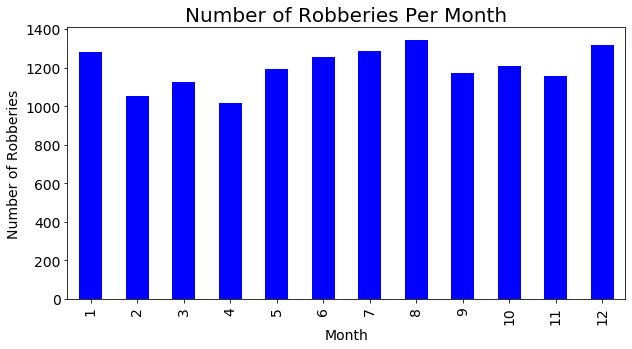

In [0]:
# Create a visualization with the data
robberies_DF = robberies_DF.sort_values(by = "month")

robberies_DF.plot(figsize = (10,5), kind = "bar", color = "blue",
                               x = "month", y = "robberies", legend = False)

plt.xlabel("Month", fontsize = 14)
plt.ylabel("Number of Robberies", fontsize = 14)
plt.title("Number of Robberies Per Month", fontsize = 20)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()


To more explicitly specify sort direction, you need to use the [asc](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.asc) and [desc](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.desc) functions if operating on a column. These allow you to specify the order in which a given column should be sorted.

Let's add now the *City* to our aggregation.

In [0]:
from pyspark.sql.functions import col, month

robberies_month_city = (robbery_crimes 
                    .select(col("City"), month(col("Incident Date")).alias("month")) 
                    .groupBy("City", "month") 
                    .count().withColumnRenamed("count", "robberies") 
                    .sort(col("City").asc(), col("month").desc())
                  )

robberies_month_city.show(10)

+------+-----+---------+
|  City|month|robberies|
+------+-----+---------+
|Austin|   12|      105|
|Austin|   11|       83|
|Austin|   10|       83|
|Austin|    9|       86|
|Austin|    8|       90|
|Austin|    7|       52|
|Austin|    6|       70|
|Austin|    5|       79|
|Austin|    4|       75|
|Austin|    3|       91|
+------+-----+---------+
only showing top 10 rows



An advanced tip is to use [asc_nulls_first](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.asc_nulls_first), [desc_nulls_first](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.desc_nulls_first), [asc_nulls_last](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.asc_nulls_last), or [desc_nulls_last](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.desc_nulls_last) to specify where you would like your null values to appear in an ordered DataFrame.

**Exercise** - Aggregating by Day of Week

Now that you know how to do aggregates, let's get the number of *Robberies* by *Day of Week* per *City*. 

Order your results by *City*  and *Day of Week* descending.

Optional to convert the Spark DataFrame to Pandas DataFrame and create a visualization.

In [0]:
# Get the number of robberies per City per Day of Week
# Order the results by City and Day of Week descending
# TODO

from pyspark.sql.functions import col, month

robberies_day_city = (robbery_crimes 
                    .select(col("City"), col("Incident Day of Week").alias("day")) 
                    .groupBy("City", "day") 
                    .count().withColumnRenamed("count", "robberies") 
                    .sort(col("City").desc(), col("day").desc())
                  )

robberies_day_city.show()

+-------------+---------+---------+
|         City|      day|robberies|
+-------------+---------+---------+
|San Francisco|Wednesday|      470|
|San Francisco|  Tuesday|      566|
|San Francisco| Thursday|      515|
|San Francisco|   Sunday|      570|
|San Francisco| Saturday|      560|
|San Francisco|   Monday|      513|
|San Francisco|   Friday|      537|
|      Chicago|Wednesday|     1355|
|      Chicago|  Tuesday|     1288|
|      Chicago| Thursday|     1281|
|      Chicago|   Sunday|     1475|
|      Chicago| Saturday|     1461|
|      Chicago|   Monday|     1423|
|      Chicago|   Friday|     1398|
|       Austin|Wednesday|      119|
|       Austin|  Tuesday|      118|
|       Austin| Thursday|      137|
|       Austin|   Sunday|      165|
|       Austin| Saturday|      161|
|       Austin|   Monday|      160|
+-------------+---------+---------+
only showing top 20 rows



**Test your solution!**

In [0]:
# Run this cell to test your solution
results = [ (r.City, r.day, r.robberies) for r in robberies_day_city.orderBy(col("City").asc(), col("day").asc()).collect() ]
expectedResults = [
  ('Austin', 'Friday', 139),
  ('Austin', 'Monday', 160),
  ('Austin', 'Saturday', 161),
  ('Austin', 'Sunday', 165),
  ('Austin', 'Thursday', 137),
  ('Austin', 'Tuesday', 118),
  ('Austin', 'Wednesday', 119),
  ('Chicago', 'Friday', 1398), 
  ('Chicago', 'Monday', 1423), 
  ('Chicago', 'Saturday', 1461), 
  ('Chicago', 'Sunday', 1475), 
  ('Chicago', 'Thursday', 1281), 
  ('Chicago', 'Tuesday', 1288), 
  ('Chicago', 'Wednesday', 1355), 
  ('San Francisco', 'Friday', 537), 
  ('San Francisco', 'Monday', 513), 
  ('San Francisco', 'Saturday', 560), 
  ('San Francisco', 'Sunday', 570),
  ('San Francisco', 'Thursday', 515), 
  ('San Francisco', 'Tuesday', 566), 
  ('San Francisco', 'Wednesday', 470)
 ]

expected = True
assert expectedResults == results, "{} does not equal expected {}".format(results, expectedResults)

print("Tests passed!")

Tests passed!


## Joins and Lookup Tables
A [join](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join) brings together two sets of data, the left and the right, by comparing the value of one or more keys of the left and right and evaluating the result of a join expression that determines
whether Spark should bring together the left set of data with the right set of data. By default Spark does an inner join.

Lookup tables are normally small, historical tables used to enrich new data passing through an ETL pipeline.


While our monthly and daily aggregations are interesting, they are flawed in the sense that we are comparing the raw number of robberies instead of the per capita robbery rates.

Let's read a DataFrame called *City_Data* which contains the estimated 2018 population values for all US cities with populations of at least 100,000. Next we will calculate the robberies rate with the following formula:

```
Per-capita values = (total robberies/ population) * 100
```

In [0]:
# Get the City data in our local drive
!wget -cq "https://datasets-pyspark-workshop.s3.amazonaws.com/City_Data.csv"

In [0]:
# Read the data into a DataFrame
city_data = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("City_Data.csv")      
            )
city_data.columns

['2018 rank', 'City', 'State', '2018 estimate', '2010 Census', 'Change']

In [0]:
# Calculate the Robbery Rate
# Using Spark DataFrames
robberies_monthly_rates = (robberies_month_city.alias("rob")
                   .join(city_data.alias("city"), robberies_month_city.City == city_data.City)
                   .withColumn("robbery_rate", (col("robberies")/col("2018 estimate"))*100)
                   .select(col("rob.City"), col("city.State"), col("rob.month").alias("Month"), 
                           col("robberies").alias("Number Robberies"), col("robbery_rate").alias("Monthly Rate"))
                   )
robberies_monthly_rates.show()

+-------+--------+-----+----------------+--------------------+
|   City|   State|Month|Number Robberies|        Monthly Rate|
+-------+--------+-----+----------------+--------------------+
| Austin|   Texas|   12|             105| 0.01088924702412435|
| Austin|   Texas|   11|              83| 0.00860769050478401|
| Austin|   Texas|   10|              83| 0.00860769050478401|
| Austin|   Texas|    9|              86| 0.00891881184833042|
| Austin|   Texas|    8|              90|  0.0093336403063923|
| Austin|   Texas|    7|              52| 0.00539276995480444|
| Austin|   Texas|    6|              70|0.007259498016082899|
| Austin|   Texas|    5|              79| 0.00819286204672213|
| Austin|   Texas|    4|              75| 0.00777803358866025|
| Austin|   Texas|    3|              91| 0.00943734742090777|
| Austin|   Texas|    2|              90|  0.0093336403063923|
| Austin|   Texas|    1|              95| 0.00985217587896965|
|Chicago|Illinois|   12|             845|0.031226972417

On the above result you can see we have twice the *City* field. If the column name used to do the join has the same name then we can send just the name of it when doing the join.

Let's see an example below.

In [0]:
# Join defining the common key
# Using Spark DataFrames
robberies_monthly_rates = (robberies_month_city.alias("rob")
                   .join(city_data.alias("city"), "City")
                   .withColumn("robbery_rate", (col("robberies")/col("2018 estimate"))*100)
                   .select(col("rob.City"), col("city.State"), col("rob.month").alias("Month"), 
                           col("robberies").alias("Number Robberies"), col("robbery_rate").alias("Monthly Rate"))
                   )
robberies_monthly_rates.show()

+-------+--------+-----+----------------+--------------------+
|   City|   State|Month|Number Robberies|        Monthly Rate|
+-------+--------+-----+----------------+--------------------+
| Austin|   Texas|   12|             105| 0.01088924702412435|
| Austin|   Texas|   11|              83| 0.00860769050478401|
| Austin|   Texas|   10|              83| 0.00860769050478401|
| Austin|   Texas|    9|              86| 0.00891881184833042|
| Austin|   Texas|    8|              90|  0.0093336403063923|
| Austin|   Texas|    7|              52| 0.00539276995480444|
| Austin|   Texas|    6|              70|0.007259498016082899|
| Austin|   Texas|    5|              79| 0.00819286204672213|
| Austin|   Texas|    4|              75| 0.00777803358866025|
| Austin|   Texas|    3|              91| 0.00943734742090777|
| Austin|   Texas|    2|              90|  0.0093336403063923|
| Austin|   Texas|    1|              95| 0.00985217587896965|
|Chicago|Illinois|   12|             845|0.031226972417

In [0]:
# Using Spark SQL
robberies_month_city.createOrReplaceTempView("robberies_month_city_view")
city_data.createOrReplaceTempView("city_data_view")
robberies_monthly_rates = spark.sql("SELECT rob.City, \
                                            city.State, \
                                            rob.month as `Month`,\
                                            rob.robberies as `Number Robberies`,\
                                            (rob.robberies/`2018 estimate`)*100 as `Monthly Rate` \
                                      FROM  robberies_month_city_view rob \
                                      LEFT JOIN  city_data_view city on rob.City == city.City")
robberies_monthly_rates.show(2)

+------+-----+-----+----------------+-------------------+
|  City|State|Month|Number Robberies|       Monthly Rate|
+------+-----+-----+----------------+-------------------+
|Austin|Texas|   12|             105|0.01088924702412435|
|Austin|Texas|   11|              83|0.00860769050478401|
+------+-----+-----+----------------+-------------------+
only showing top 2 rows



**Exercise** - Join City Data with daily robberies 

Join the city data with your daily robberies DataFrame. Your final DataFrame should have the following columns:
- City: city name.
- month: incident month
- robberies: total of robberies per month per city
- robbery_rate: per capita robbery rates.

In [0]:
# Use robberies_day_city DataFrame
# Select City, State, Incident Day of Week, Robberies
# Define a new column "Daily Rate" as the (robberies/2018 estimate)*100
# Round the "Daily Rate" to 6 places using the round method
# Save it to a DataFrame call robberies_daily_rates
# TODO
from pyspark.sql.functions import round, col

robberies_daily_rates = (robberies_day_city.alias("rob")
                    .join(city_data.alias("city"), "City")
                    .withColumn("Daily Rate", (col("robberies")/col("2018 estimate")*100))
                    .select(col("rob.City"), col("city.State"), col("rob.day").alias("Day"), 
                           col("robberies").alias("Number Robberies"), round(col("Daily Rate"), 6).alias("Daily_Rate"))
                    .orderBy("City", "Day")
                    )
                    
robberies_daily_rates.show(truncate=False)

+-------------+----------+---------+----------------+----------+
|City         |State     |Day      |Number Robberies|Daily_Rate|
+-------------+----------+---------+----------------+----------+
|Austin       |Texas     |Friday   |139             |0.014415  |
|Austin       |Texas     |Monday   |160             |0.016593  |
|Austin       |Texas     |Saturday |161             |0.016697  |
|Austin       |Texas     |Sunday   |165             |0.017112  |
|Austin       |Texas     |Thursday |137             |0.014208  |
|Austin       |Texas     |Tuesday  |118             |0.012237  |
|Austin       |Texas     |Wednesday|119             |0.012341  |
|Chicago      |Illinois  |Friday   |1398            |0.051663  |
|Chicago      |Illinois  |Monday   |1423            |0.052587  |
|Chicago      |Illinois  |Saturday |1461            |0.053991  |
|Chicago      |Illinois  |Sunday   |1475            |0.054509  |
|Chicago      |Illinois  |Thursday |1281            |0.047339  |
|Chicago      |Illinois  

**Test your solution!**

In [0]:
# Run this cell to test your solution.
results = [ (r.City, r.State, r.Day, r.Daily_Rate) for r in robberies_daily_rates.orderBy("City", "Day").collect() ]

expectedResults = [('Austin', 'Texas', 'Friday', 0.014415), 
                   ('Austin', 'Texas', 'Monday', 0.016593), 
                   ('Austin', 'Texas', 'Saturday', 0.016697), 
                   ('Austin', 'Texas', 'Sunday', 0.017112), 
                   ('Austin', 'Texas', 'Thursday', 0.014208), 
                   ('Austin', 'Texas', 'Tuesday', 0.012237), 
                   ('Austin', 'Texas', 'Wednesday', 0.012341), 
                   ('Chicago', 'Illinois', 'Friday', 0.051663), 
                   ('Chicago', 'Illinois', 'Monday', 0.052587), 
                   ('Chicago', 'Illinois', 'Saturday', 0.053991), 
                   ('Chicago', 'Illinois', 'Sunday', 0.054509), 
                   ('Chicago', 'Illinois', 'Thursday', 0.047339), 
                   ('Chicago', 'Illinois', 'Tuesday', 0.047598), 
                   ('Chicago', 'Illinois', 'Wednesday', 0.050074), 
                   ('San Francisco', 'California', 'Friday', 0.060794), 
                   ('San Francisco', 'California', 'Monday', 0.058077), 
                   ('San Francisco', 'California', 'Saturday', 0.063398), 
                   ('San Francisco', 'California', 'Sunday', 0.06453), 
                   ('San Francisco', 'California', 'Thursday', 0.058304), 
                   ('San Francisco', 'California', 'Tuesday', 0.064078), 
                   ('San Francisco', 'California', 'Wednesday', 0.053209)] 

expected = True
assert expectedResults == results, "{} does not equal expected {}".format(results, expectedResults)

print("Tests passed!")

Tests passed!


## Checkpoint

In [0]:
# Get Monthly Rates data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/robberies_monthly_rates.csv
# Get Daily Rates data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/robberies_daily_rates.csv
# Get Crimes DF data
!wget -cq https://datasets-pyspark-workshop.s3.amazonaws.com/Crimes_DF.csv

In [0]:
# Read the Monthly data
robberies_monthly_rates = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("robberies_monthly_rates.csv")    
            ) 
robberies_monthly_rates = robberies_monthly_rates.repartition(36)
robberies_monthly_rates.rdd.getNumPartitions()

36

In [0]:
# Read the Daily data
robberies_daily_rates = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("robberies_daily_rates.csv")    
            )  
robberies_daily_rates = robberies_daily_rates.repartition(21)
robberies_daily_rates.rdd.getNumPartitions()

21

In [0]:
# Read the Crimes DF data
crimes_df = (spark.read                                      
                  .format("csv")                             
                  .option("header", "true")                  
                  .option("inferSchema", "true")             
                  .load("Crimes_DF.csv")    
            )  
crimes_df = crimes_df.repartition(6)
crimes_df.rdd.getNumPartitions()

6

# Data Load

The core structure for writing data is as follows: 

```
DataFrameWriter.format(...).option(...).partitionBy(...).bucketBy(...).sortBy(...).save()
```

The foundation for writing data is quite similar to that of reading data. Instead of the DataFrameReader, we have the [DataFrameWriter](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter). Because we always need to write out some given data source, we access the DataFrameWriter on a per-DataFrame basis via the write attribute:

```
dataFrame.write
```

After we have a DataFrameWriter, we specify three values: the format, a series of options, and the save mode. At a minimum, you must supply a path.

```
DataFrameWriter.write.format(...).option("key", "value").save(<path>)
```

Just like the data sources used to read the data, Spark supports the same ones for writing data back:
- [CSV](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.csv)
- [JSON](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.json)
- [Parquet](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.parquet)
- [ORC](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.orc)
- [JDBC/ODBC](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.jdbc) connections
- [Plain-text](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.text) files

### Save modes
Save modes specify what will happen if Spark finds data at the specified location (assuming all
else equal).

![alt text](https://images-workshop.s3.amazonaws.com/Spark_write_modes.png)

Source: Spark: The Definitive Guide. Big Data Processing Made Simple By Matei Zaharia, Bill Chambers


Just as with reading data, there are a variety of [options](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameWriter.csv) for writing data when
we write CSV files. This is a subset of the reading options because many do not apply when
writing data (like maxColumns and inferSchema).

Let's save our final DataFrames to disk using the DataFrame Writer methods.

In [0]:
# Save the Monthly Robberies Rates to disk
(robberies_monthly_rates.write
                        .format('csv')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Monthly Data"))

As you can see our Spark write method saved the file into several parts. The number of files or data written is dependent on the number of partitions the DataFrame has at the time you write out the data. By default, one file is written per partition of the data. This means that although we specify a “file,” it’s actually a number of files within a folder, with the name of the specified file, with one file per each partition that is written.

We can see how many partitions this file has by invoking the `rdd.getNumPartitions` method.

In [0]:
# Check number of partitions
robberies_monthly_rates.rdd.getNumPartitions()

36

**Exercise** - Save the Daily Rates DataFrame

Now let's save the Daily Rates DataFrame and check its partitions.

In [0]:
# Save the Daily Robberies Rates to disk using the csv format
# Check the number of partitions using the rdd.getNumPartitions() method
# TODO
(robberies_daily_rates.write
                        .format('csv')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Daily Data"))

robberies_daily_rates.rdd.getNumPartitions()

21

**Exercise** - Write Data to json format



In [0]:
# Use the json format to save data
# Use the "overwrite" mode and header = true
# Write data to the "Monthly Data JSON" folder
# TODO
(robberies_monthly_rates.write
                        .format('json')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Monthly Data JSON"))

You can see above that there was one file created per partition, and the entire DataFrame was written out as a folder. If you check each file you will see that they have one JSON object per line.

## Repartition and Coalesce
An important optimization opportunity is to partition the data according to some frequently
filtered columns.
Repartition will incur a full shuffle of the data, regardless of whether one is necessary. This
means that you should typically only [repartition](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.repartition) when the future number of partitions is greater
than your current number of partitions or when you are looking to partition by a set of columns.

Let's see how many partitions we have in the original joined DataFrame *crimes_df*. This DataFrame has 524,139 records.

In [0]:
# Get number of partitions
crimes_df.rdd.getNumPartitions()

6

In [0]:
# If we want to repartition with a greater number of partitions
crimes_df_repartition10 = crimes_df.repartition(10)
crimes_df_repartition10.rdd.getNumPartitions()

10

Now we can save this data to our local drive and we should see 10 files in the destination folder.

In [0]:
(crimes_df_repartition10.write
                        .format('csv')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Crimes Data Repartition"))

Use [coalesce](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.coalesce) if you want to combine partitions. This operation will shuffle your data into n partitions.

**Warning!** If you use .coalesce(n) with a number greater than the current partitions, this DataFrame method will have no effect.

In [0]:
crimes_df_coalesce6 = crimes_df_repartition10.coalesce(6)
(crimes_df_coalesce6.write
                        .format('csv')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Crimes Data Coalesce"))

crimes_df_coalesce6.rdd.getNumPartitions()

6

**Exercise** - Coalesce DataFrames

Use the coalesce method to reduce the partitions to 1 on both `robberies_monthly_rates` and `robberies_daily_rates` so we had only a file instead of several.

In [0]:
# Use coalesce to reduce the partitions to 1
# Assign the new DataFrame to robberies_monthly_rates_coalesce1
# Write the DataFrame to a csv file to disk.
# TODO

robberies_monthly_rates_coalesce1 = robberies_monthly_rates.coalesce(1)
(robberies_monthly_rates_coalesce1.write
                        .format('csv')
                        .option("header", "true")
                        .mode("overwrite")
                        .save("Monthly Data Coalesce")
)
                    
robberies_monthly_rates_coalesce1.rdd.getNumPartitions()

1

**Test your solution!**

In [0]:
# Run this cell to test your solution.
partitions = robberies_monthly_rates_coalesce1.rdd.getNumPartitions()

expected = True
assert str(expected) == str(partitions == 1), "{} does not equal expected {}".format(expected, partitions == 1)

print("Tests passed")

Tests passed


### Repartition and Coalesce - Summary

|| Repartition | Coalesce|
|--|--|--|
|Partitions| Creates new partitions| Uses existing ones|
|Shuffles|Full shuffle|Partial shuffle|
|Size|Equal sized partitions|Different sized partitions|

## Writing to Databases

In the context of JDBC databases writes, the number of partitions determine the number of connections used to push data through the JDBC API. We use the repartition and coalesce methods to control this parallelism:


| Function | Transformation Type | Use | Evenly distributes data across partitions? |
| :----------------|:----------------|:----------------|:----------------| 
| `.coalesce(n)`   | narrow (does not shuffle data) | reduce the number of partitions | no |
| `.repartition(n)`| wide (includes a shuffle operation) | increase the number of partitions | yes |


### Upserts
Upserts insert a record into a database if it doesn't already exist, and updates the existing record if it does.  **Upserts are not supported in core Spark** due to the transactional nature of upserting and the immutable nature of Spark.

Let's see an example on how to write a DataFrame to a DB in Postgressql:
```
(jdbcDF.write
      .format("jdbc")
      .option("url", "jdbc:postgresql:dbserver")
      .option("dbtable", "schema.tablename")
      .option("user", "username")
      .option("password", "password")
      .mode("append")
      .save()
)
```

# Best Practices

## Use Spark DataFrames
Spark DataFrames are optimized and therefore also faster than RDDs. Especially when you’re working with structured data, you should really consider switching your RDD to a DataFrame.

![alt text](https://images-workshop.s3.amazonaws.com/DataFrame_performance.png)

Source: Databricks Blog

https://databricks.com/blog/2015/02/17/introducing-dataframes-in-spark-for-large-scale-data-science.html

## Schema Definition

Deciding whether you need to define a schema prior to reading in your data depends on your use case. For ad hoc analysis, schema-on-read usually works just fine (although at times it can be a bit slow with plain-text file formats like CSV or JSON). However, this can also lead to precision issues like a long type incorrectly set as an integer when reading in a file. 
When using Spark for production Extract, Transform, and Load (ETL), it is often a good idea to define your schemas manually, especially when working with untyped data sources like CSV and JSON because schema inference can vary depending on the type of data that you read in.

## Don’t call collect() on large DataFrames
By calling collect() on any DataFrame, you drag data back into your applications from the nodes. Each DataFrame element will be copy onto the single driver program, which will run out of memory and crash. Given the fact that you want to make use of Spark in the most efficient way possible, it’s not a good idea to call collect() on large DataFrames.

## Caching

Caching data is one way to improve query performance.  Cached data is maintained on a cluster rather than forgotten at the end of a query.  Without caching, Spark reads the data from its source again after every action. 

There are a number of different storage levels with caching, which are variants on memory, disk, or a combination of the too.  By default, Spark's storage level is `MEMORY_AND_DISK`

[ cache](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.cache) is the most common way of caching data while [persist](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.persist) allows for setting the storage level.

**WARNING!** It's worth noting that caching should be done with care since data cached at the wrong time can lead to less performant clusters.

Let's use the *%timeit* function to see the average time for counting an uncached DataFrame.

In [0]:
%timeit crimes_df.count()

10 loops, best of 3: 46.8 ms per loop


Cache the DataFrame. An action will materialize the cache (store ir on the Spark cluster)

In [0]:
(crimes_df
    .cache()
    .count()
)

%timeit crimes_df.count()

10 loops, best of 3: 49 ms per loop


## UDF

When you use the function, there are essentially two different things that occur. If the function is written in Scala or Java, you can use it within the Java Virtual Machine (JVM). This means that
there will be little performance penalty aside from the fact that you can’t take advantage of code generation capabilities that Spark has for built-in functions. There can be performance issues if
you create or use a lot of objects;
If the function is written in Python, something quite different happens. Spark starts a Python process on the worker, serializes all of the data to a format that Python can understand
(remember, it was in the JVM earlier), executes the function row by row on that data in the Python process, and then finally returns the results of the row operations to the JVM and Spark.
Figure 6-2 provides an overview of the process.

**WARNING!**
Starting this Python process is expensive, but the real cost is in serializing the data to Python. This is costly for two reasons: 
- It is an expensive computation
- After the data enters Python, Spark cannot manage the memory of the worker. This means that you could potentially cause a worker to fail
if it becomes resource constrained (because both the JVM and Python are competing for memory on the same machine). 

It's  recommended that you write your UDFs in Scala or Java—the small amount of time it should take you to write the function in Scala will always yield significant speed ups, and on
top of that, you can still use the function from Python!

## Partition and Coalesce

- If you know that you’re going to be filtering by a certain column often, it can be worth
repartitioning based on that column.
- Use Coalesce if you want to combine partitions. This operation will shuffle your data without a full shuffle.
- While a partition refers to the distribution of data, a slot/core refers to the distribution of computation. As general rule of thumb, the number of partitions should be a multiple of the number of cores. For instance, with 5 partitions and 8 slots, 3 of the slots will be underutilied. With 9 partitions and 8 slots, a job will take twice as long as it waits for the extra partition to finish.

![alt text](https://images-workshop.s3.amazonaws.com/Spark_archictecture.png)

Source: A Gentle Introduction to Apache Spark on Databricks

https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/346304/2168141618055043/484361/latest.html

## Managing File Size - small file problem

Managing file sizes is an important factor not so much for writing data but reading it later on.
When you’re writing lots of small files, there’s a significant metadata overhead that you incur
managing all of those files. Spark especially does not do well with small files, although many file
systems (like HDFS) don’t handle lots of small files well, either. You might hear this referred to
as the “small file problem.” The opposite is also true: you don’t want files that are too large
either, because it becomes inefficient to have to read entire blocks of data when you need only a
few rows.

You can use the maxRecordsPerFile option and specify a number of your choosing. This allows you to better control file sizes by controlling the number of records that are written to each file. 

For example, if you set an option for a writer as 
```
df.write.option("maxRecordsPerFile", 5000), 
```
Spark will ensure that files will contain at most 5,000 records.

# References

- Download Spark: http://apache.osuosl.org/spark/
- San Francisco Crime Dataset: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783
- Austin Crime Dataset: https://data.austintexas.gov/Public-Safety/Crime-Reports-2018/vmn9-3bvu
- Chicago Crime Dataset: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
- Population dataset: https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population



- PySpark Documentation: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html
- Spark: The Definitive Guide. Big Data Processing Made Simple
By Matei Zaharia, Bill Chambers
Publisher: O'Reilly Media
Release Date: February 2018
- Mastering Apache Spark: https://jaceklaskowski.gitbooks.io/mastering-apache-spark/
- SP820: ETL Part 1: Data Extraction (AWS Databricks) https://academy.databricks.com/course/SP820
- SP821: ETL Part 2: Transformations and Loads (AWS Databricks) https://academy.databricks.com/course/SP821
- SP822: ETL Part 3: Production (AWS Databricks) https://academy.databricks.com/course/SP822